`python3 -m pip install -U pandas plotly nbformat`

`pip install "https://github.com/DCMLab/wavescapes/archive/refs/heads/johannes.zip"`

In [170]:
%reload_ext autoreload
%autoreload 2
import numpy as np

from etl import get_dfts, get_mag_phase_mx, get_metadata, get_most_resonant, get_pcms, get_pcvs, test_dict_keys, \
  get_correlations, make_feature_vectors, get_metric, get_partition_entropy, \
  get_percentage_resonance, get_moment_of_inertia, get_non_coherence

from utils import get_coeff, long2utm

from wavescapes.color import circular_hue
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
import statsmodels.api as sm

## Settings

In [83]:
DEBUSSY_REPO = '.'
DATA_FOLDER = '~/DATA/debussy_figures/data'
DATA_FOLDER = './data'
EXAMPLE_FNAME = 'l000_etude'
LONG_FORMAT = False

## Loading metadata
Metadata for all pieces contained in the dataset.

In [84]:
metadata = get_metadata(DEBUSSY_REPO)
metadata.columns

Metadata for 68 files.


Index(['rel_paths', 'last_mc', 'last_mn', 'length_qb', 'length_qb_unfolded',
       'all_notes_qb', 'TimeSig', 'KeySig', 'label_count', 'composer',
       'workTitle', 'movementNumber', 'movementTitle', 'workNumber', 'poet',
       'lyricist', 'arranger', 'copyright', 'creationDate', 'mscVersion',
       'platform', 'source', 'translator', 'musescore', 'ambitus', 'comments',
       'composed_end', 'composed_start', 'originalFormat', 'pdf',
       'staff_1_ambitus', 'staff_1_instrument', 'staff_2_ambitus',
       'staff_2_instrument', 'staff_3_ambitus', 'staff_3_instrument',
       'transcriber', 'typesetter', 'year', 'median_recording',
       'qb_per_minute', 'sounding_notes_per_qb', 'sounding_notes_per_minute'],
      dtype='object')

In [85]:
years_ordinal = {val:year for year, val in enumerate(np.sort(metadata.year.unique()))}
years_ordinal

{1880.0: 0,
 1888.0: 1,
 1890.0: 2,
 1891.0: 3,
 1892.0: 4,
 1894.0: 5,
 1901.0: 6,
 1903.0: 7,
 1904.0: 8,
 1905.0: 9,
 1907.0: 10,
 1908.0: 11,
 1909.0: 12,
 1909.5: 13,
 1910.0: 14,
 1911.0: 15,
 1914.0: 16,
 1915.0: 17,
 1917.0: 18}

In [86]:
metadata['years_ordinal'] = metadata.year.fillna(1880.0).apply(lambda x: years_ordinal[x])

In [87]:
metadata.years_ordinal.head(10)

fnames
l000_etude                     17
l000_soirs                     18
l009_danse                      0
l066-01_arabesques_premiere     1
l066-02_arabesques_deuxieme     3
l067_mazurka                    2
l068_reverie                    2
l069_tarentelle                 2
l070_ballade                    2
l071_valse                      2
Name: years_ordinal, dtype: int64

The column `year` contains composition years as the middle between beginning and end  of the composition span.

In [88]:
metadata.year.head(10)

fnames
l000_etude                     1915.0
l000_soirs                     1917.0
l009_danse                     1880.0
l066-01_arabesques_premiere    1888.0
l066-02_arabesques_deuxieme    1891.0
l067_mazurka                   1890.0
l068_reverie                   1890.0
l069_tarentelle                1890.0
l070_ballade                   1890.0
l071_valse                     1890.0
Name: year, dtype: float64

Series `median_recording` contains median recording times in seconds, retrieved from the Spotify API. the Spotify API.

In [89]:
metadata.median_recording.head(10)

fnames
l000_etude                     272.5530
l000_soirs                     145.8265
l009_danse                     124.5995
l066-01_arabesques_premiere    240.7780
l066-02_arabesques_deuxieme    213.9330
l067_mazurka                   175.9130
l068_reverie                   265.4265
l069_tarentelle                331.5290
l070_ballade                   396.0200
l071_valse                     221.4500
Name: median_recording, dtype: float64

Columns mirroring a piece's activity are currently:
* `qb_per_minute`: the pieces' lengths (expressed as 'qb' = quarterbeats) normalized by the median recording times; a proxy for the tempo
* `sounding_notes_per_minute`: the summed length of all notes normalized by the piece's duration (in minutes)
* `sounding_notes_per_qb`: the summed length of all notes normalized by the piece's length (in qb)
Other measures of activity could be, for example, 'onsets per beat/second' or 'distinct pitch classes per beat/second'.

## Loading Pitch Class Vectors (PCVs)
An `{fname -> pd.DataFrame}` dictionary where each `(NX12)` DataFrame contains the absolute durations (expressed in quarter nots) of the 12 chromatic pitch classes for the `N` slices of length = 1 quarter note that make up the piece `fname`. The IntervalIndex reflects each slice's position in the piece. Set `pandas` to False to retrieve NumPy arrays without the IntervalIndex and column names.

In [6]:
pcvs = get_pcvs(DEBUSSY_REPO, pandas=True)
test_dict_keys(pcvs, metadata)
pcvs[EXAMPLE_FNAME].head(5)

Found matrices for all files listed in metadata.tsv.


,0,1,2,3,4,5,6,7,8,9,10,11
iv,,,,,,,,,,,,
"[0.0, 1.0)",0.167,0.0,0.0,0.334,0.0,0.000,0.0,0.0,1.334,0.0,0.167,0.0
"[1.0, 2.0)",0.167,0.0,0.0,0.334,0.0,0.334,0.0,0.0,1.167,0.0,0.000,0.0
"[2.0, 3.0)",0.167,0.0,0.0,0.334,0.0,0.334,0.0,0.0,0.167,0.0,0.000,0.0
"[3.0, 4.0)",0.167,0.0,0.0,0.334,0.0,0.334,0.0,0.0,0.167,0.0,0.000,0.0
"[4.0, 5.0)",0.167,0.0,0.0,0.334,0.0,0.334,0.0,0.0,1.167,0.0,0.000,0.0


## Loading Pitch Class Matrices
An `{fname -> np.array}` dictionary where each `(NxNx12)` array contains the aggregated PCVs for all segments that make up a piece. The square matrices contain values only in the upper right triangle, with the lower left beneath the diagonal is filled with zeros. The values are arranged such that row 0 correponds to the original PCV, row 1 the aggregated PCVs for all segments of length = 2 quarter notes, etc. For getting the segment reaching from slice 3 to 5 (including), i.e. length 3, the coordinates are `(2, 5)` (think x = 'length - 1' and y = index of the last slice included). The following example shows the upper left 3x3 submatrix where the first three entries (which are PCVs of size 12) correspond to the first three PCVs above, the first three of the second row to their sums padded with a 0-PCV, and the first three of the third row corresponding to the sum of row 0, padded with another 0-PCV.

In [ ]:
pcms = get_pcms(DEBUSSY_REPO, long=LONG_FORMAT)
test_dict_keys(pcms, metadata)
pcms[EXAMPLE_FNAME].shape

## Loading Discrete Fourier Transforms
`{fname -> np.array}` containing `(NxNx7)` complex matrices. For instance, here's the first element, a size 7 complex vector with DFT coefficients 0 through 6:

In [ ]:
dfts = get_dfts(DEBUSSY_REPO, long=LONG_FORMAT)
test_dict_keys(dfts, metadata)
dfts[EXAMPLE_FNAME].shape

You can view the 7 complex numbers as magnitude-phase pairs

In [ ]:
get_coeff(dfts[EXAMPLE_FNAME], 0, 0)

or even as strings where the numbers are rounded and angles are shown in degrees:

In [38]:
get_coeff(dfts[EXAMPLE_FNAME], 0, 0, deg=True)

array([['2.0+0°'],
       ['1.05+247°'],
       ['1.36+132°'],
       ['1.38+346°'],
       ['1.04+256°'],
       ['1.69+104°'],
       ['1.33+0°']], dtype='<U9')

## Loading magnitude-phase matrices
`{fname -> np.array}` where each of the `(NxNx6x2)` matrices contains the 6 relevant DFT coefficients converted into magnitude-phase pairs where the magnitudes have undergone at least one normalization, i.e. are all within [0,1]. The files have been pre-computed and are loaded from g-zipped pickled matrices.

The parameter `norm_params` can be one or several `(how, indulge)` pairs where `indulge` is a boolean and `how ∈ {'0c', 'post_norm', 'max_weighted', 'max'}`.

In [90]:
norm_params = ('0c', True)
mag_phase_mx_dict = get_mag_phase_mx(DATA_FOLDER, norm_params=norm_params, long=LONG_FORMAT)
test_dict_keys(mag_phase_mx_dict, metadata)
mag_phase_mx_dict[EXAMPLE_FNAME].shape


Found matrices for all files listed in metadata.tsv.


(284, 284, 6, 2)

In [91]:
mpm = mag_phase_mx_dict[EXAMPLE_FNAME]
colors = circular_hue(mpm[...,1,:], output_rgba=True, ignore_phase=True)
colors.shape

(284, 284)

Note that the phases (2nd column) are the same that we inspected above via `get_coeff()` whereas the magnitudes are now normalized by the first (now absent) coefficient 0.

In [92]:
mag_phase_mx_dict[EXAMPLE_FNAME][0]

array([[[ 5.38214271e-01,  1.97790855e+00],
        [ 7.49750250e-01, -2.30792065e+00],
        [ 8.33166833e-01,  2.45331397e-01],
        [ 7.49750250e-01,  1.81282734e+00],
        [ 8.71880604e-01, -1.82039166e+00],
        [ 6.66333666e-01,  8.32251143e-17]],

       [[ 4.44424363e-01,  2.51616207e+00],
        [ 4.99500500e-01, -2.25090725e+00],
        [ 6.66333666e-01,  0.00000000e+00],
        [ 1.00000000e+00,  1.76042734e+00],
        [ 7.72101656e-01, -1.65477615e+00],
        [ 3.32667333e-01,  8.33500769e-17]],

       [[ 4.10683603e-01, -2.09439510e+00],
        [ 1.66666667e-01,  2.09439510e+00],
        [ 3.33333333e-01,  0.00000000e+00],
        [ 1.00000000e+00,  1.04719755e+00],
        [ 7.44016936e-01, -1.04719755e+00],
        [ 3.33333333e-01, -3.14159265e+00]],

       ...,

       [[ 1.78632795e-01, -2.61799388e-01],
        [ 3.33333333e-01, -2.09439510e+00],
        [ 1.00000000e+00,  4.63647609e-01],
        [ 1.00000000e+00,  5.23598776e-01],
        [ 6.6

## Loading most resonant DFT coefficients
This cell depends on the previously loaded magnitude-phase matrices, i.e. a conscious choice of a normalization method has been made above.

`get_most_resonant` returns three `{fname -> nd.array}` dictionaries where for each piece, the three `(NxN)` matrices correspond to

1. the index between 0 and 5 of the most resonant of the six DFT coefficient 1 through 6
2. its magnitude
3. the inverse entropy of the 6 magnitudes

In [93]:
max_coeffs, max_mags, inv_entropies = get_most_resonant(mag_phase_mx_dict, )
np.column_stack((max_coeffs[EXAMPLE_FNAME][:3],
max_mags[EXAMPLE_FNAME][:3],
inv_entropies[EXAMPLE_FNAME][:3]))

array([[4.        , 3.        , 3.        , ..., 0.18687664, 0.18687664,
        0.18687664],
       [0.        , 3.        , 3.        , ..., 0.18687664, 0.18687664,
        0.18687664],
       [0.        , 0.        , 3.        , ..., 0.24929173, 0.18687664,
        0.18687664]])

## Loading major, minor, and tritone correlations

This cell loads pickled matrices. To re-compute correlations from pitch-class matrices, use `get_maj_min_coeffs()` for major and minor correlations and `get_ttms()` for tritone-ness matrices.

In [94]:
correl_dict = get_correlations(DATA_FOLDER, long=LONG_FORMAT)
test_dict_keys(correl_dict, metadata)
correl_dict[EXAMPLE_FNAME].shape

Found matrices for all files listed in metadata.tsv.


(284, 284, 3)

## Loading pickled 9-fold vectors

The function is a shortcut for
* loading a particular kind of pickled normalized magnitude-phase-matrices
* loading pickled tritone, major, and minor coefficients
* concatenating them toegther

In [95]:
norm_params = ('0c', True)
ninefold_dict = make_feature_vectors(DATA_FOLDER, norm_params=norm_params, long=LONG_FORMAT)
test_dict_keys(ninefold_dict, metadata)
ninefold_dict[EXAMPLE_FNAME].shape

Found matrices for all files listed in metadata.tsv.


(284, 284, 9)

In [143]:
metadata_metrics = metadata.copy()

# Center of mass

Computing the center of mass of each coefficient for all the pieces. Uses `mag_phase_mx_dict` as input and outputs the vertical center of mass as a fraction of the height of the wavescape. `get_center_of_mass` returns one `{fname -> list}` dictionary containing the 6 np.floats, one for each coefficient.

Found matrices for all files listed in metadata.tsv.
The example center of mass list has len 6.
Example results [0.26600092984200885, 0.21161124832720876, 0.2431548982901923, 0.2216396770564771, 0.2852747163984566, 0.21447410060868968]


,rel_paths,last_mc,last_mn,length_qb,length_qb_unfolded,all_notes_qb,TimeSig,KeySig,label_count,composer,...,mean_resonances_3,mean_resonances_4,mean_resonances_5,mean_resonances_6,center_of_mass_1,center_of_mass_2,center_of_mass_3,center_of_mass_4,center_of_mass_5,center_of_mass_6
fnames,,,,,,,,,,,,,,,,,,,,,
l000_etude,MS3,73,71,284.0,284.0,959.25,1: 4/4,"1: -4, 7: 0, 9: -5, 38: 0, 42: -4, 48: -3, 57:...",0,Claude Debussy,...,0.103886,0.151917,0.151747,0.061724,0.266001,0.211611,0.243155,0.22164,0.285275,0.214474


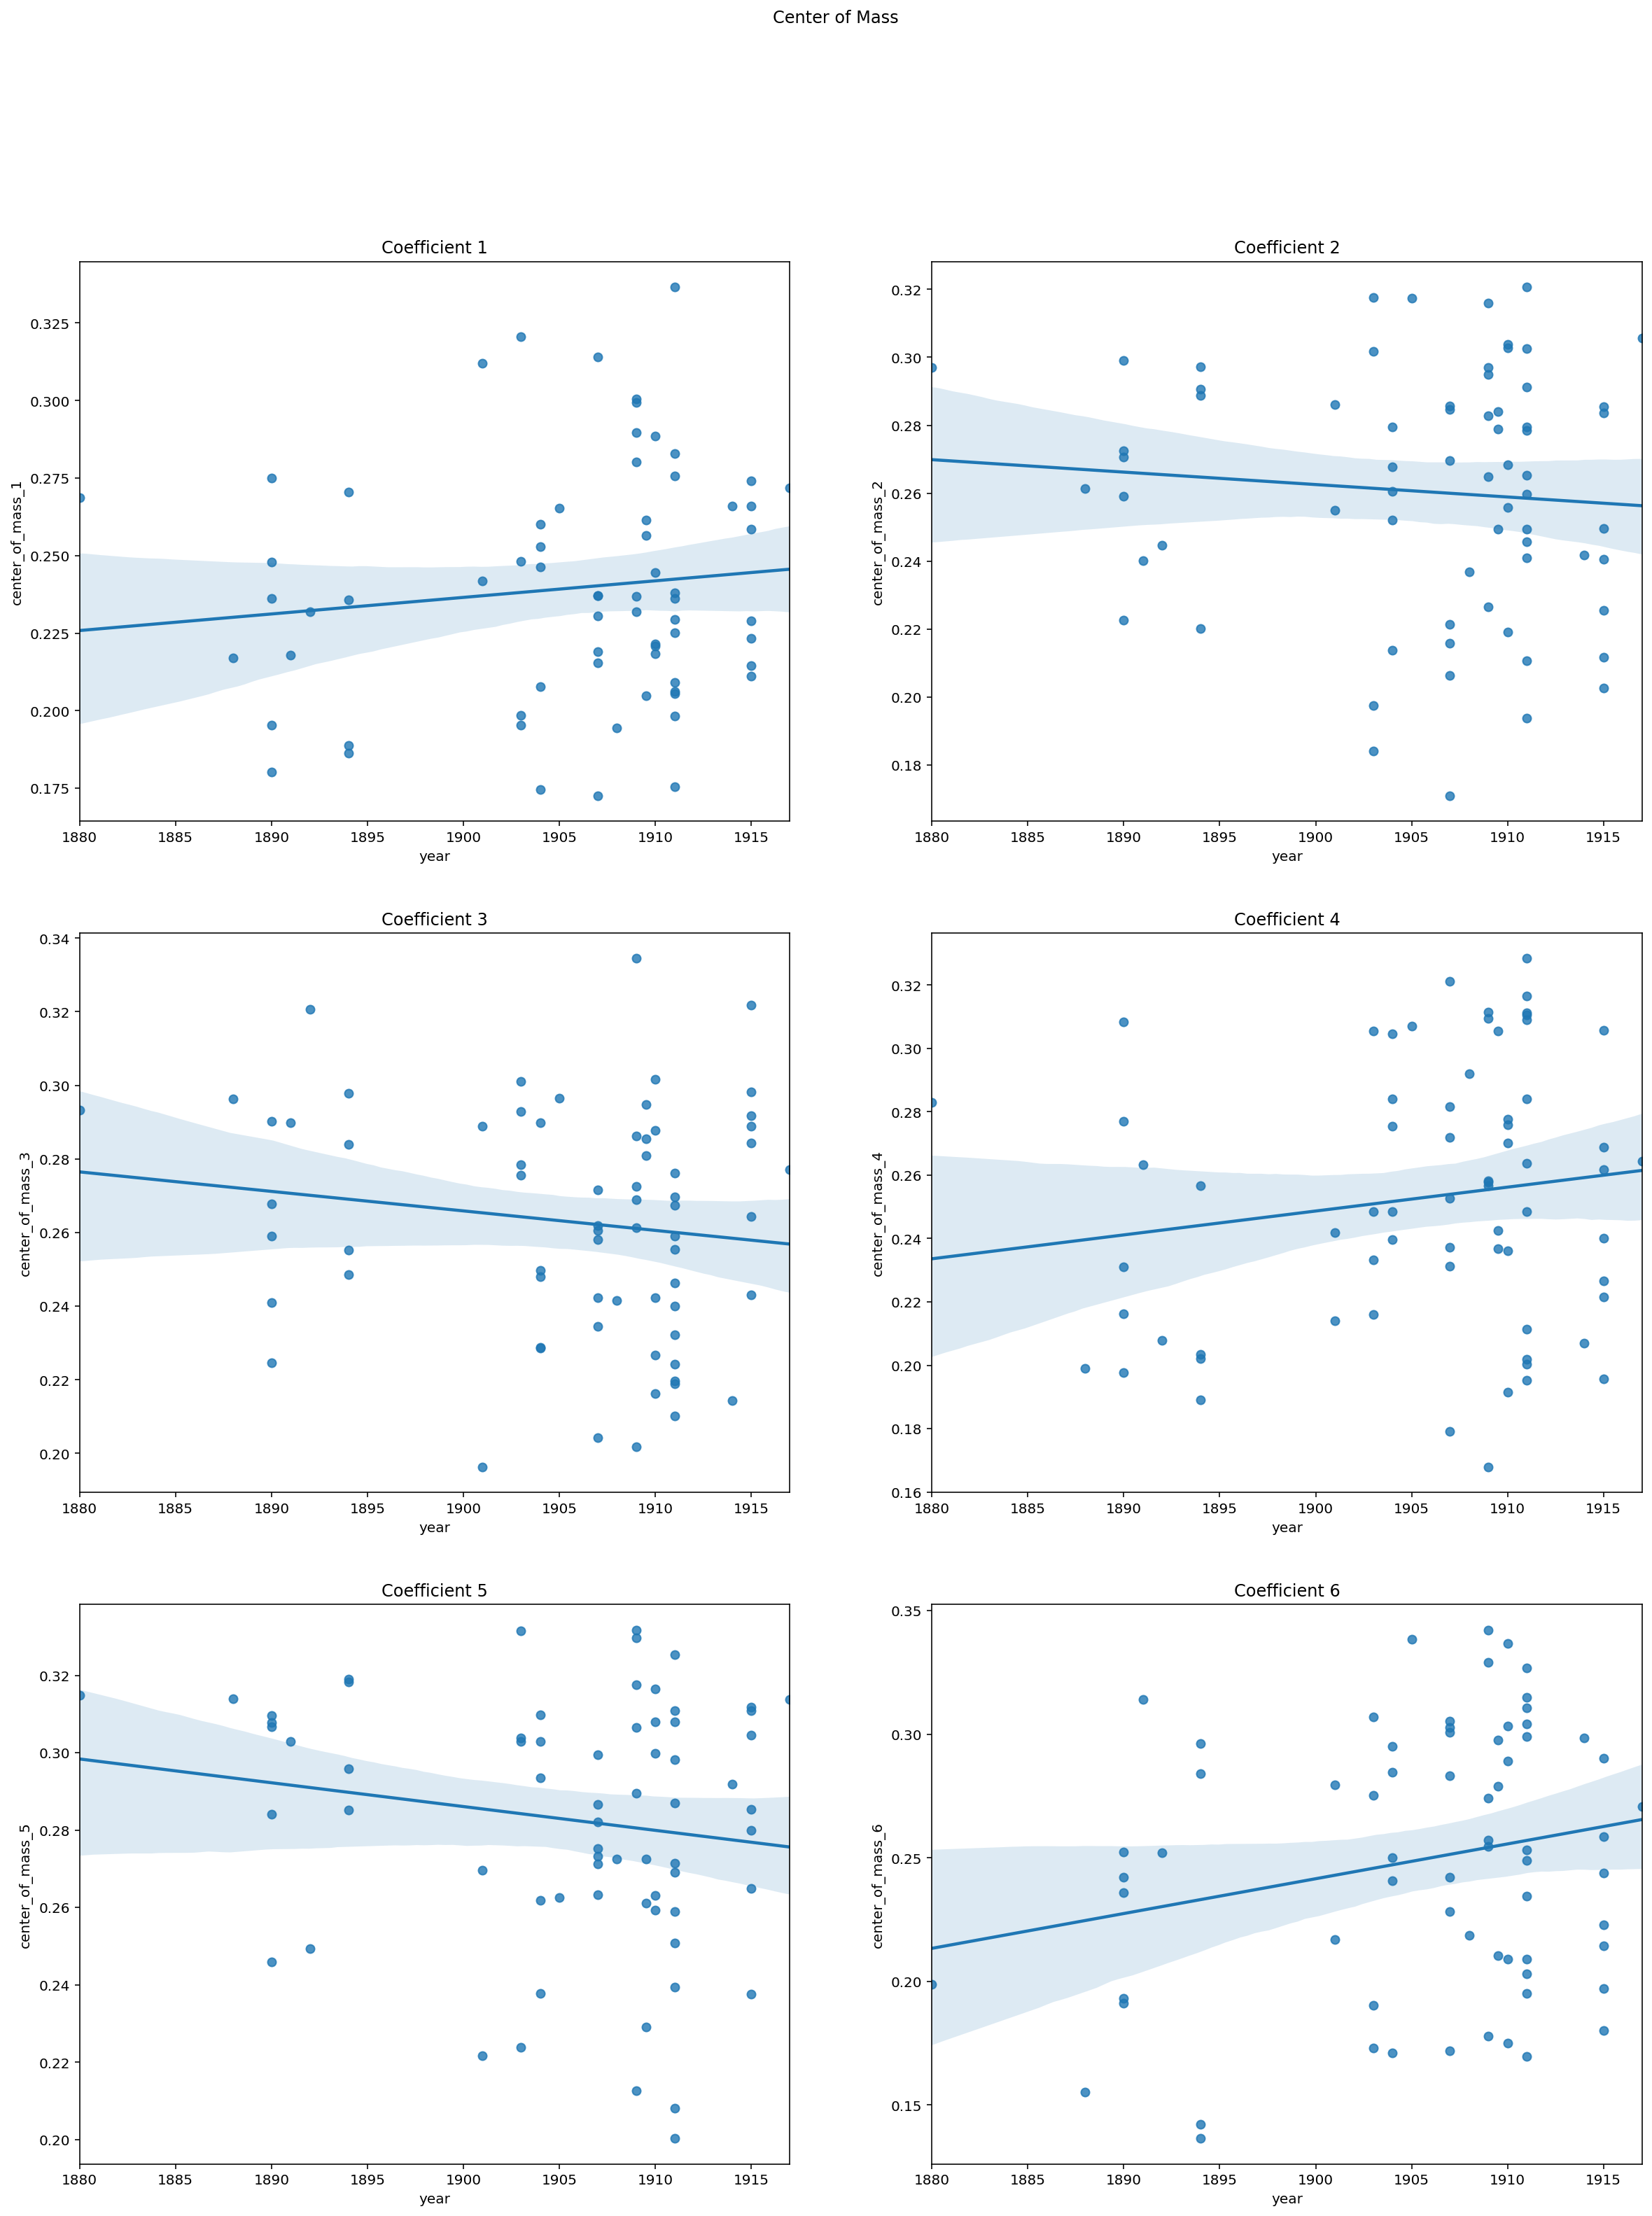

In [171]:
cols = [f"center_of_mass_{i}" for i in range(1,7)]
metadata_metrics = get_metric('center_of_mass', metadata_metrics, 
                              mag_phase_mx_dict=mag_phase_mx_dict, 
                              cols=cols, store_matrix=True, 
                              show_plot=True, save_name='center_of_mass', title='Center of Mass')
metadata_metrics.head(1)

Found matrices for all files listed in metadata.tsv.
The example center of mass list has len 6.
Example results [0.26600092984200885, 0.21161124832720876, 0.2431548982901923, 0.2216396770564771, 0.2852747163984566, 0.21447410060868968]


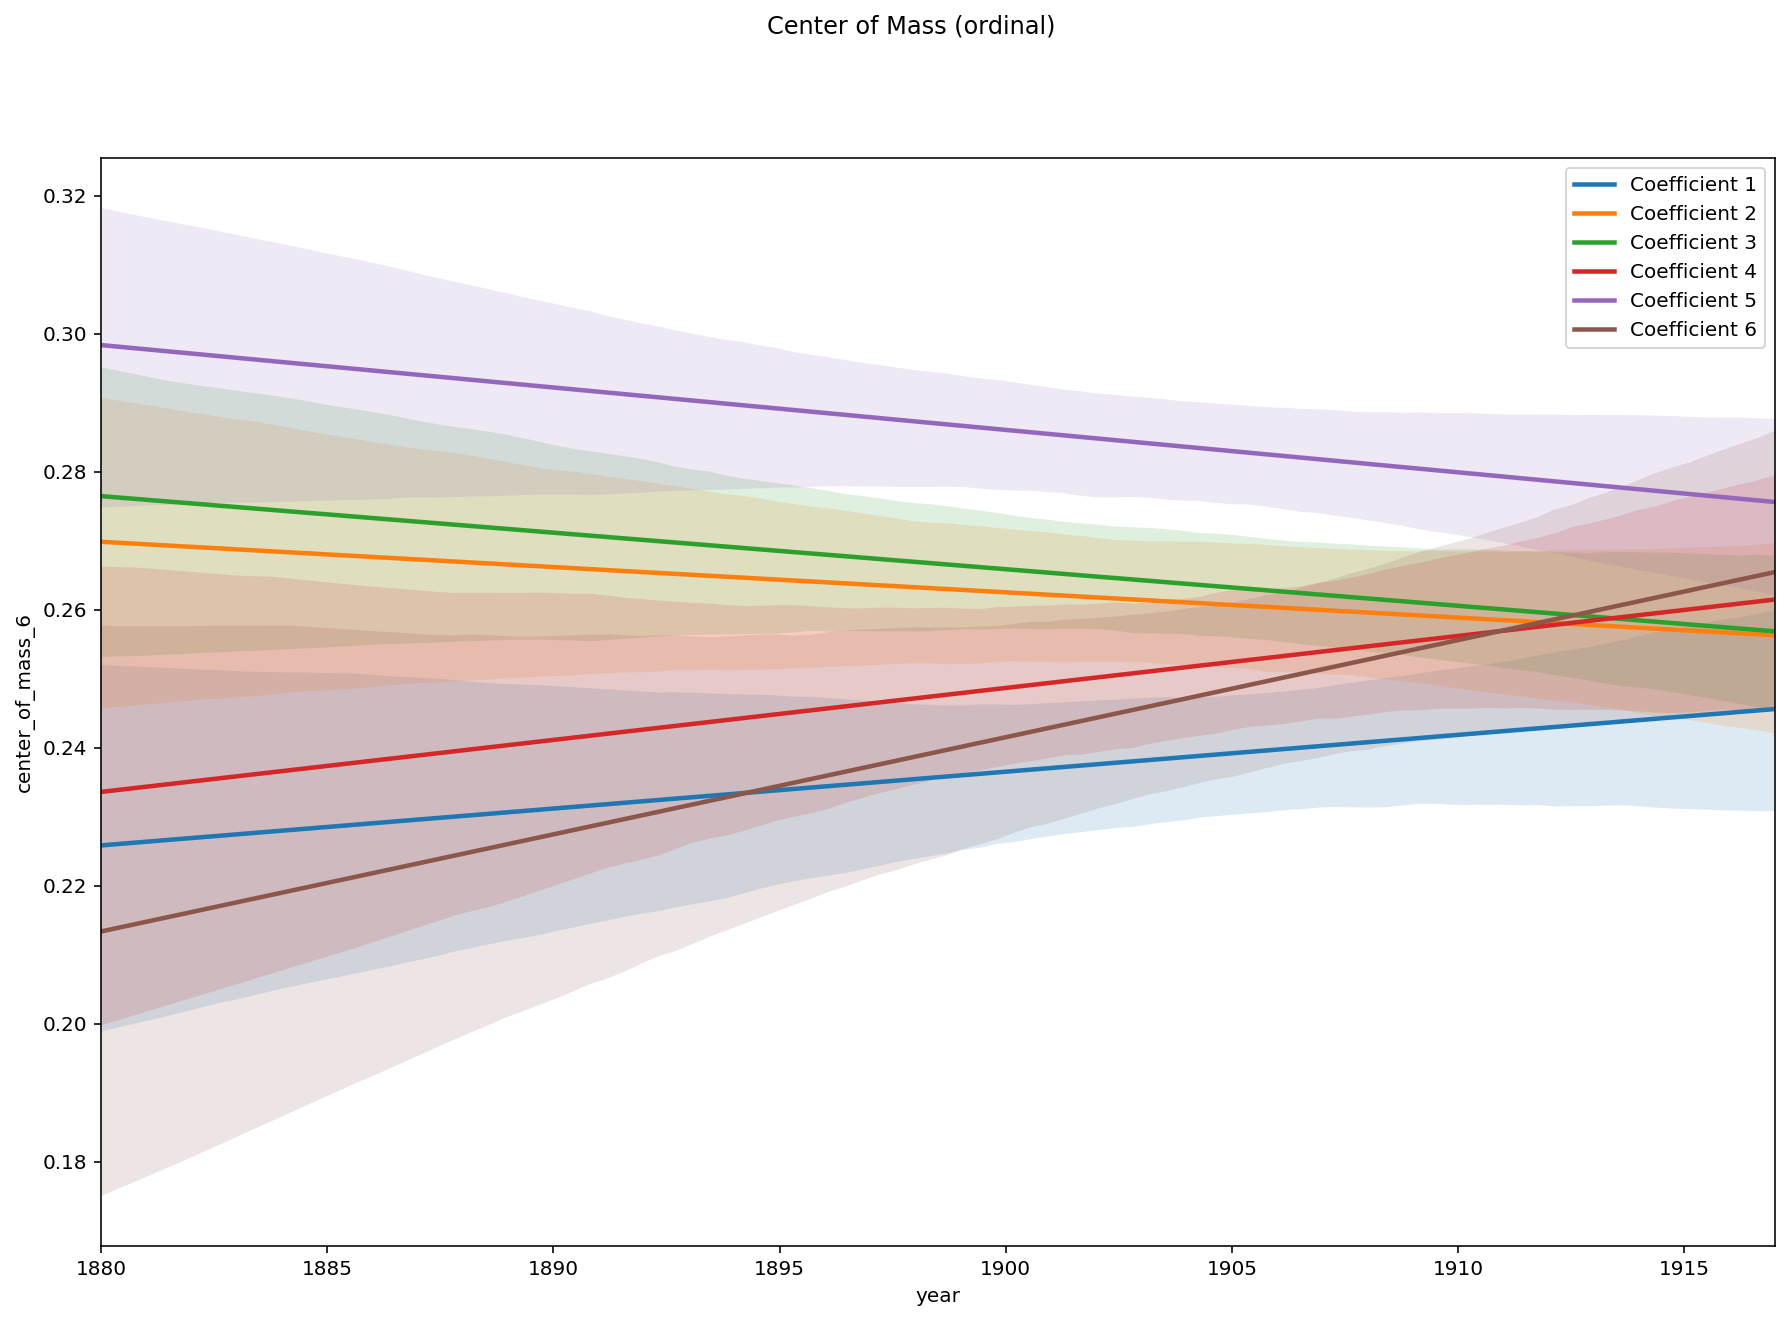

In [172]:

metadata_metrics = get_metric('center_of_mass', metadata_metrics, 
                              mag_phase_mx_dict=mag_phase_mx_dict,
                              cols=cols, store_matrix=True, 
                              show_plot=True, save_name='center_of_mass', title='Center of Mass (ordinal)',
                              unified=True)


Found matrices for all files listed in metadata.tsv.
The example center of mass list has len 6.
Example results [0.26600092984200885, 0.21161124832720876, 0.2431548982901923, 0.2216396770564771, 0.2852747163984566, 0.21447410060868968]


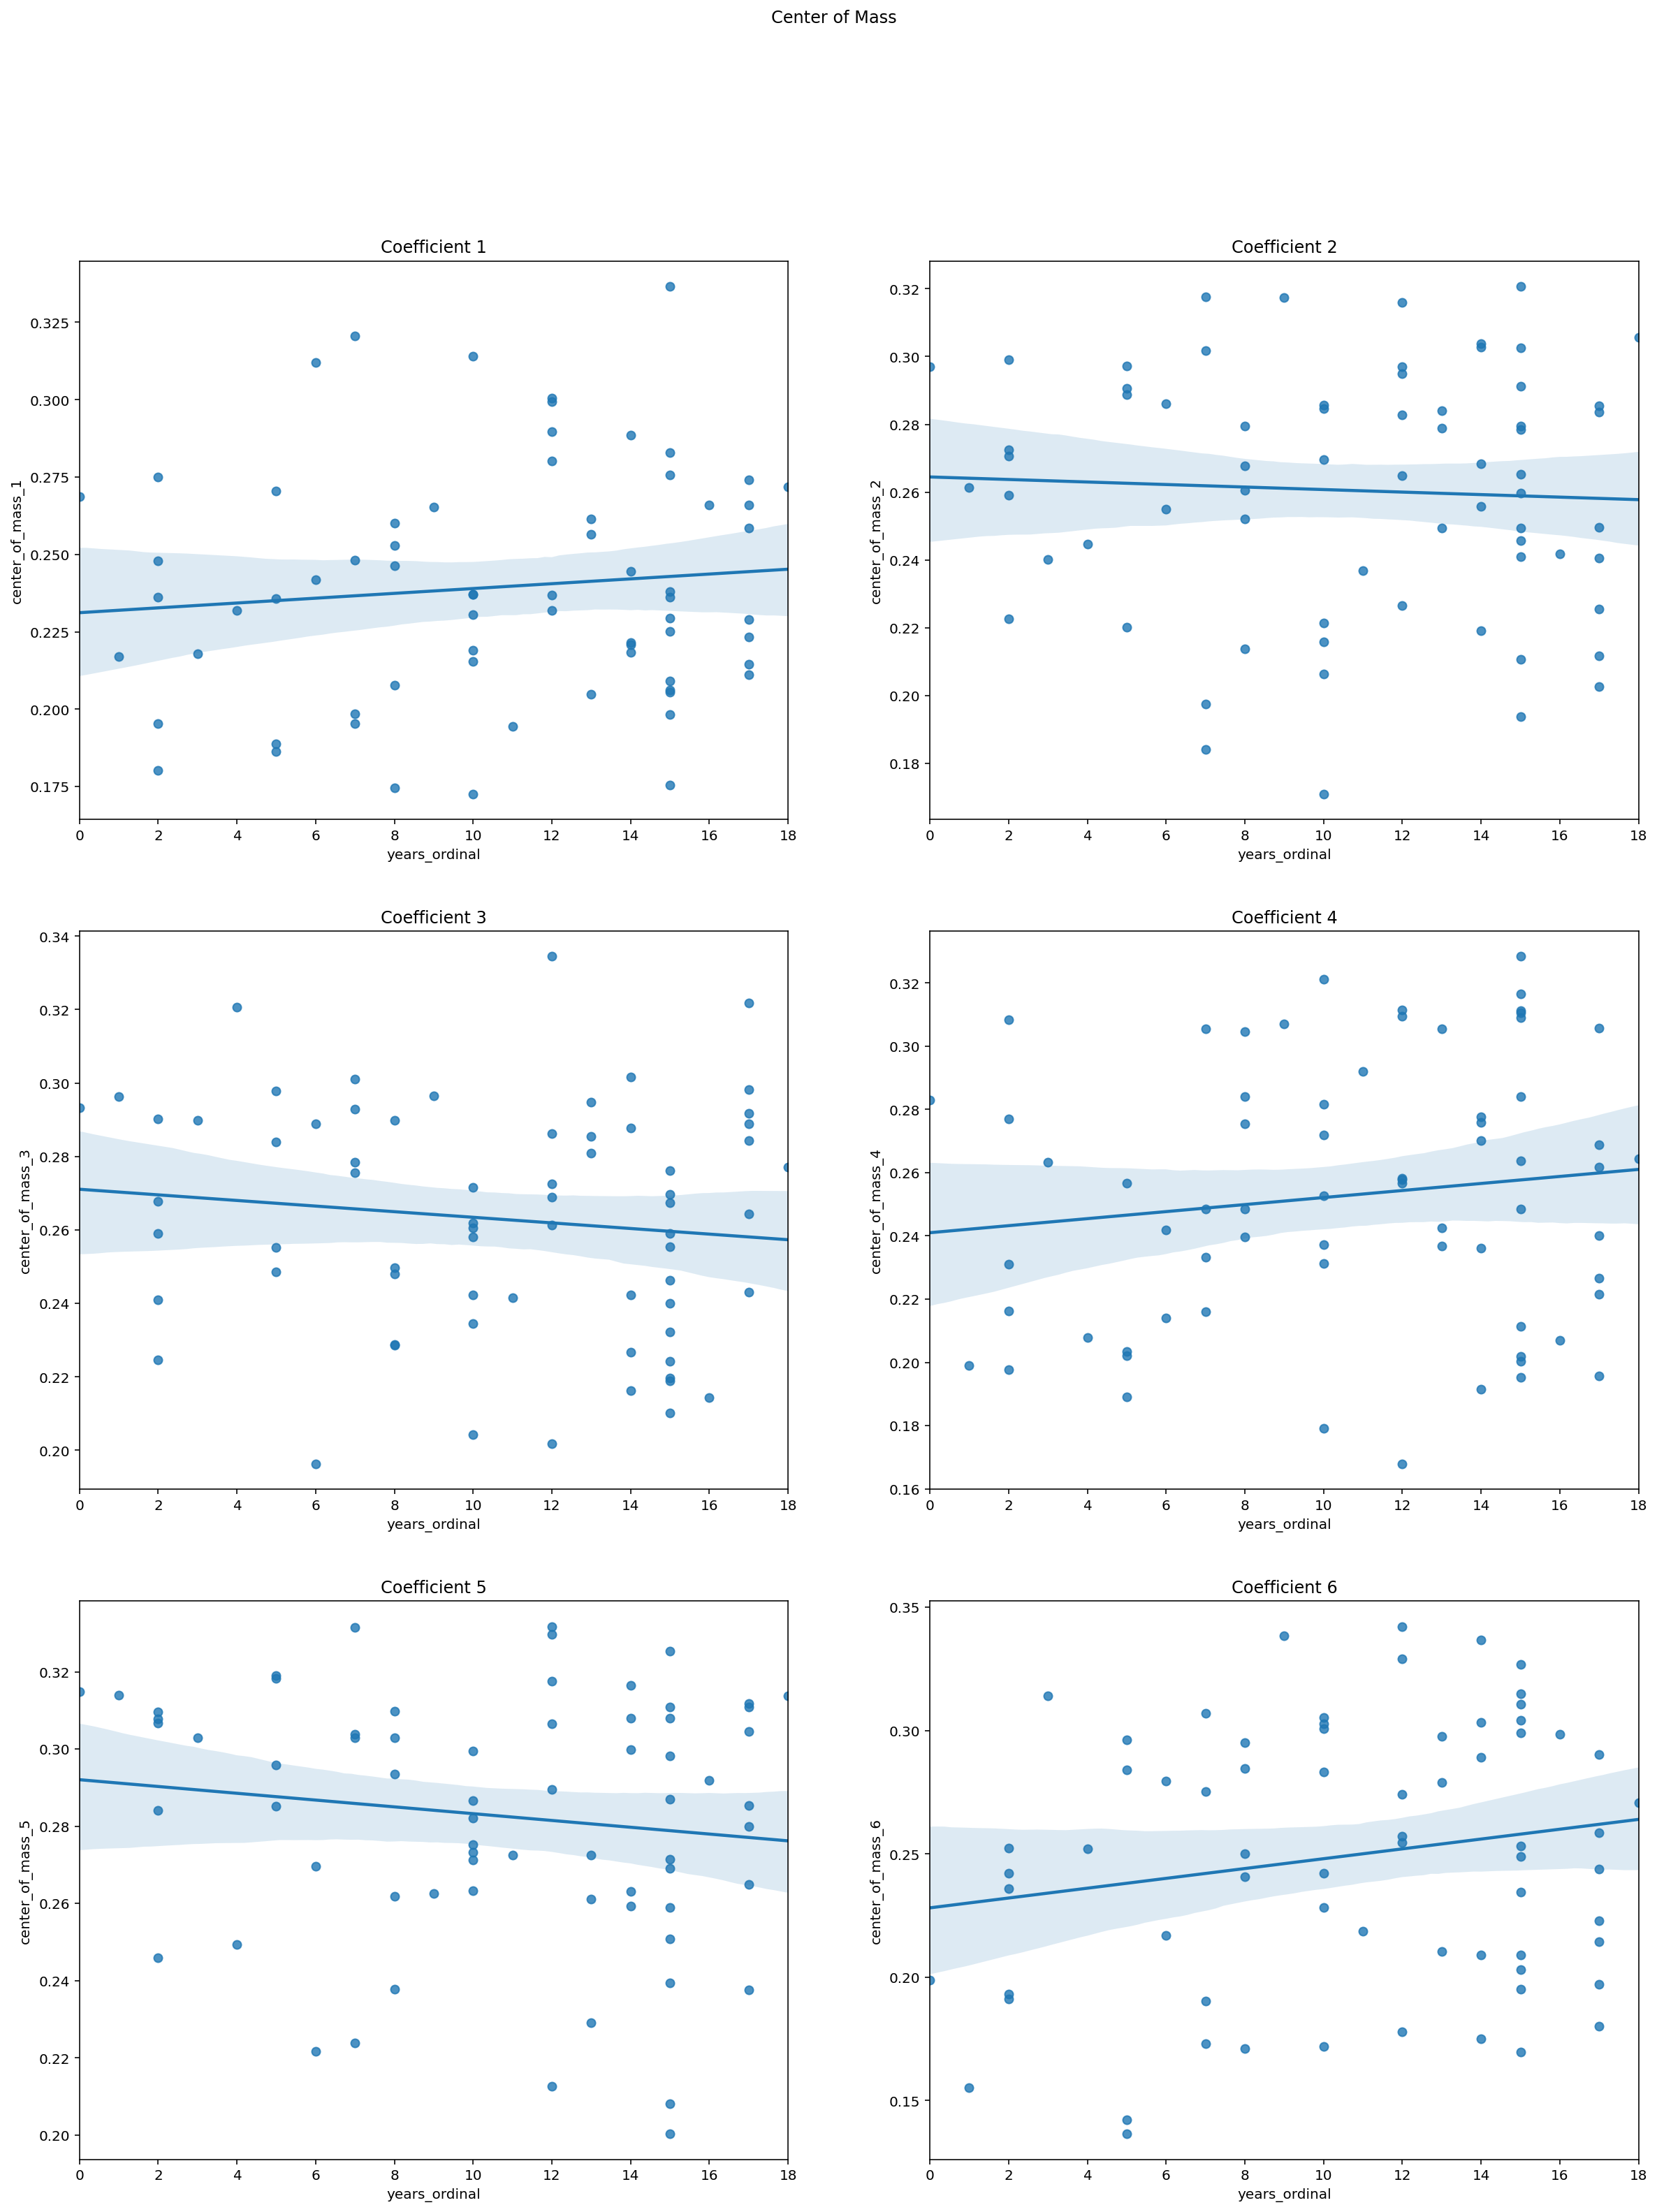

In [173]:

metadata_metrics = get_metric('center_of_mass', metadata_metrics, 
                              mag_phase_mx_dict=mag_phase_mx_dict,
                              cols=cols, store_matrix=True, 
                                     show_plot=True, save_name='center_of_mass', title='Center of Mass',
                                     ordinal=True, ordinal_col='years_ordinal')


Found matrices for all files listed in metadata.tsv.
The example center of mass list has len 6.
Example results [0.26600092984200885, 0.21161124832720876, 0.2431548982901923, 0.2216396770564771, 0.2852747163984566, 0.21447410060868968]


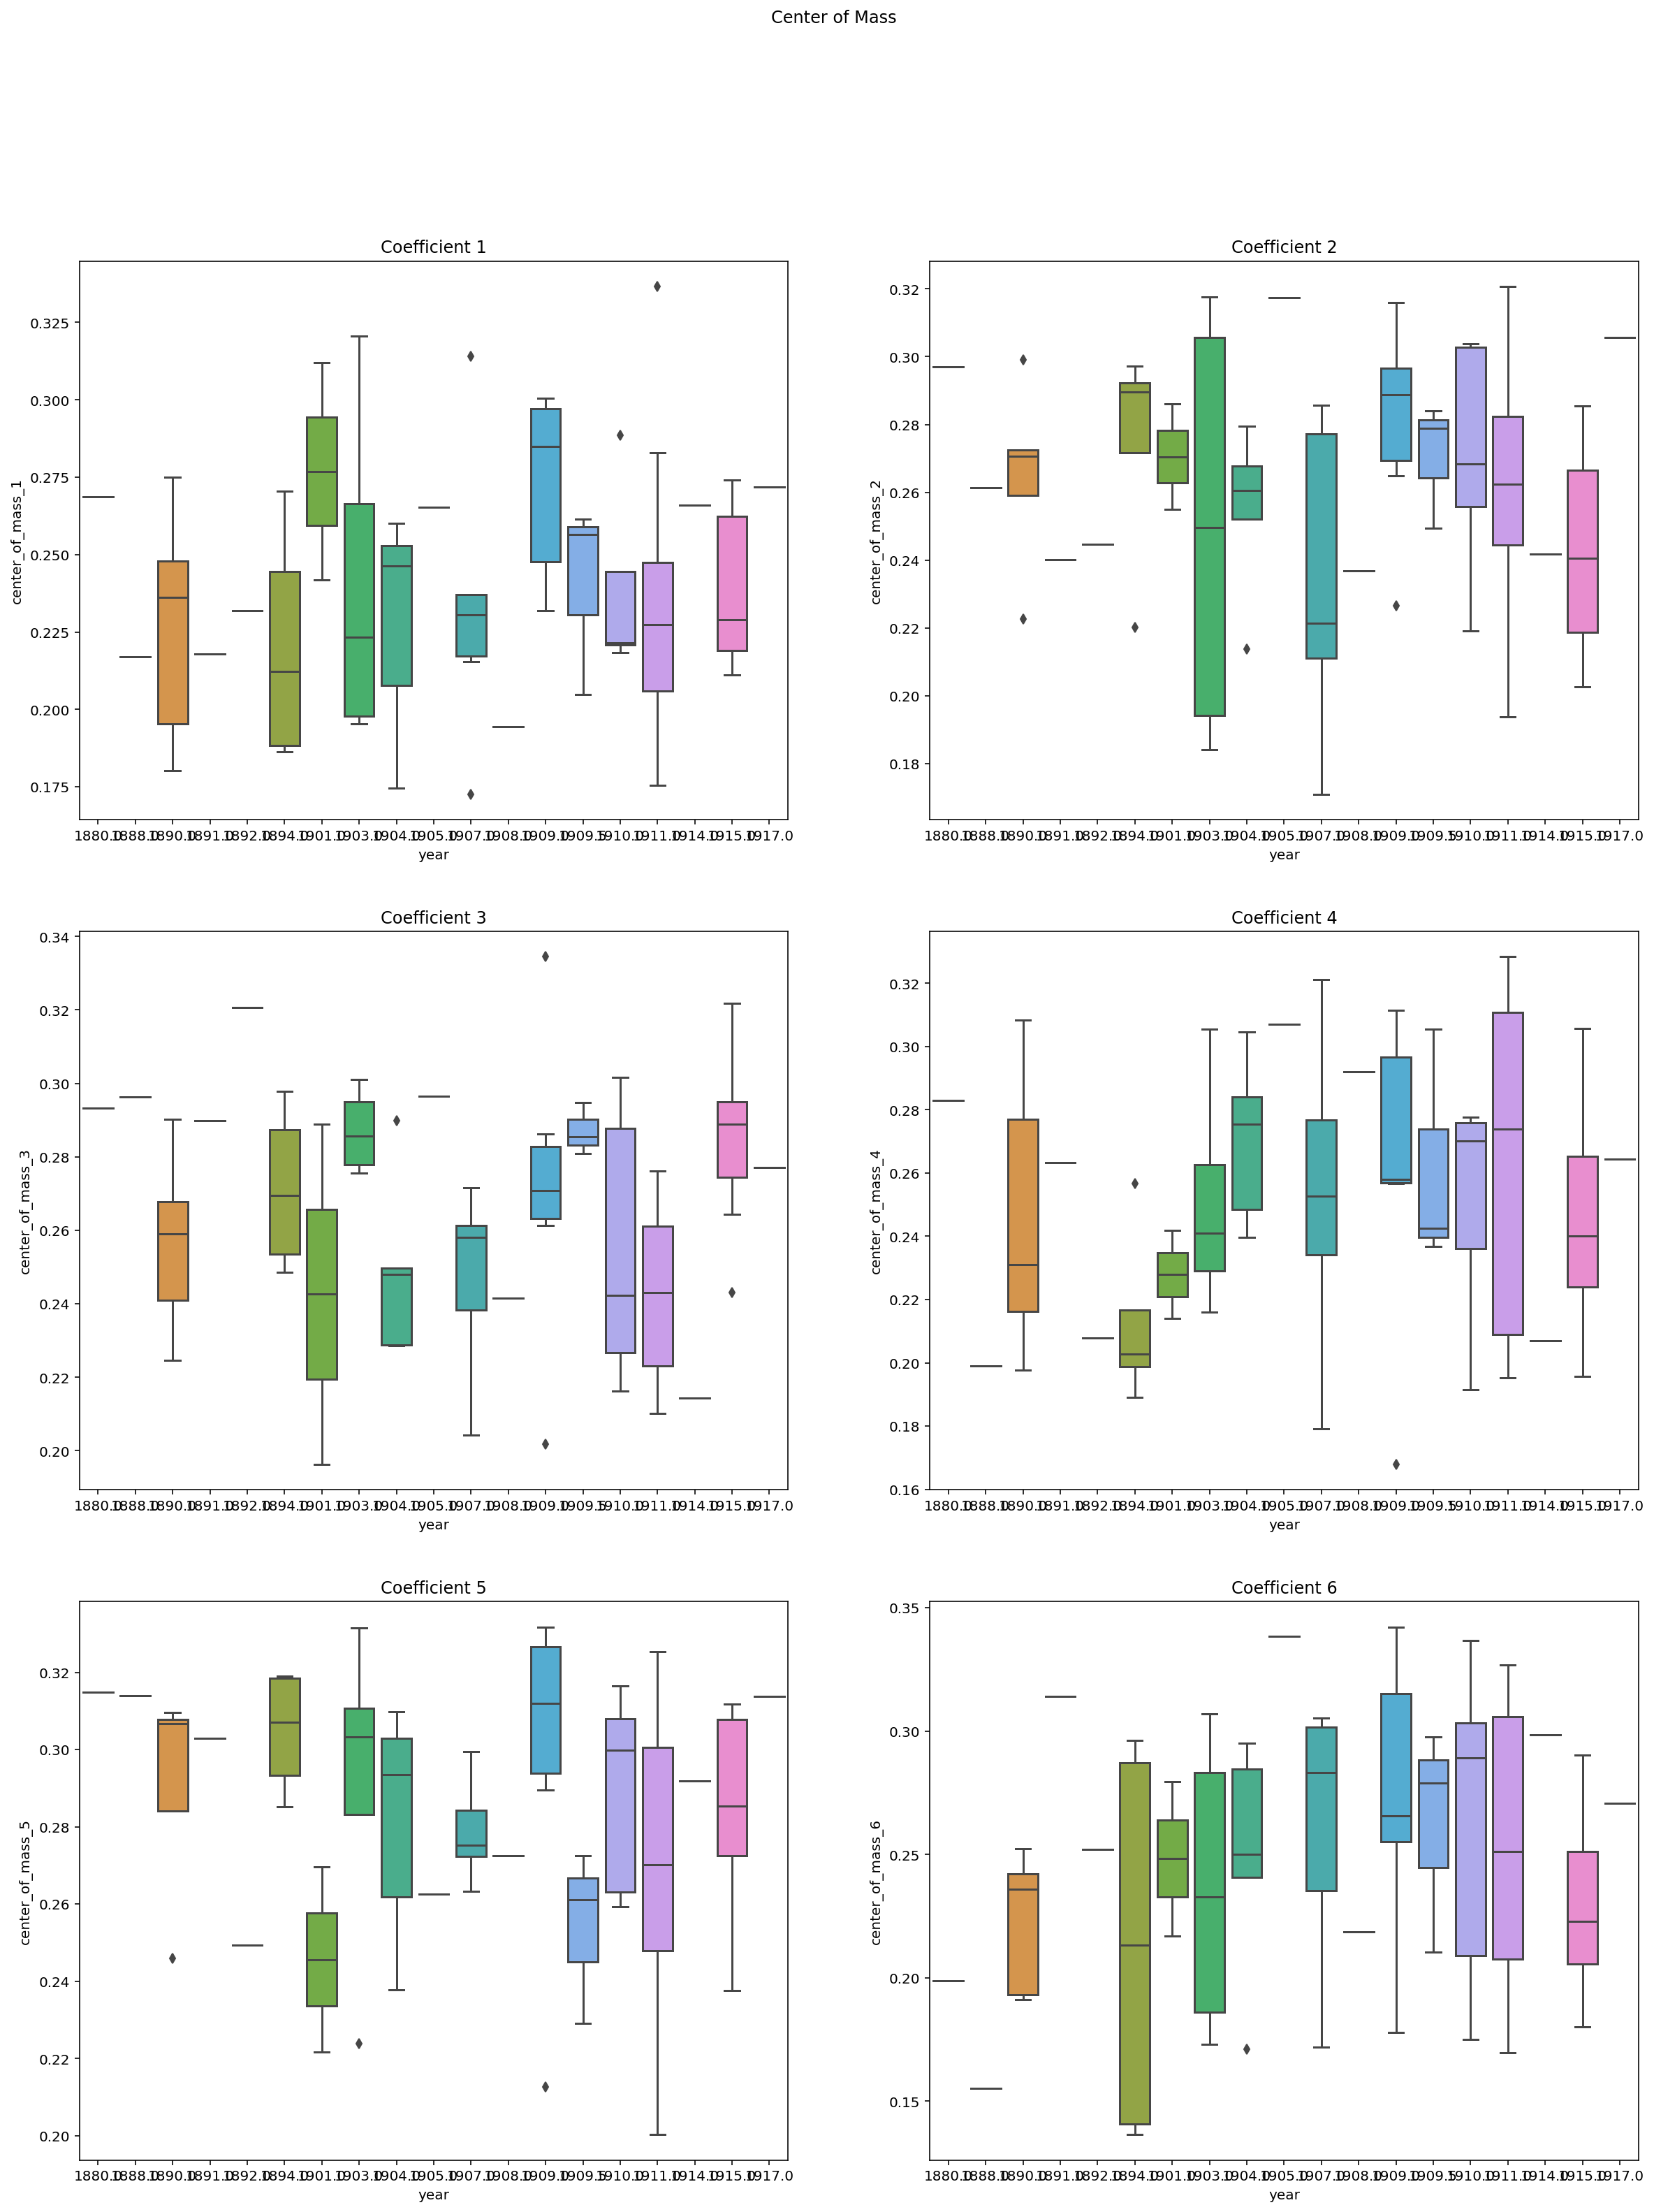

In [174]:

metadata_metrics = get_metric('center_of_mass', metadata_metrics, 
                              mag_phase_mx_dict=mag_phase_mx_dict,
                              cols=cols, store_matrix=True, 
                                     show_plot=True, save_name='center_of_mass', title='Center of Mass', boxplot=True)


In [175]:

metadata_metrics = get_metric('center_of_mass', metadata_metrics, 
                              mag_phase_mx_dict=mag_phase_mx_dict, cols=cols, store_matrix=True, testing=True)

Found matrices for all files listed in metadata.tsv.
The example center of mass list has len 6.
Example results [0.26600092984200885, 0.21161124832720876, 0.2431548982901923, 0.2216396770564771, 0.2852747163984566, 0.21447410060868968]
testing results
                            OLS Regression Results                            
Dep. Variable:       center_of_mass_1   R-squared:                       0.014
Model:                            OLS   Adj. R-squared:                 -0.016
Method:                 Least Squares   F-statistic:                    0.4563
Date:                Sat, 26 Feb 2022   Prob (F-statistic):              0.636
Time:                        10:30:20   Log-Likelihood:                -96.014
No. Observations:                  68   AIC:                             198.0
Df Residuals:                      65   BIC:                             204.7
Df Model:                           2                                         
Covariance Type:            nonrobust

C:\Users\ludov\anaconda3\envs\ada\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\ludov\anaconda3\envs\ada\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\ludov\anaconda3\envs\ada\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\ludov\anaconda3\envs\ada\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\ludov\anaconda3\envs\ada\lib\site-packages\

# Mean Resonance

Same concept as above but this time it is not weighted by the height

Found matrices for all files listed in metadata.tsv.
The example center of mass list has len 6.
Example results [0.05352486 0.0653218  0.10388608 0.15191741 0.15174701 0.06172378]


,rel_paths,last_mc,last_mn,length_qb,length_qb_unfolded,all_notes_qb,TimeSig,KeySig,label_count,composer,...,center_of_mass_3,center_of_mass_4,center_of_mass_5,center_of_mass_6,mean_resonances_1,mean_resonances_2,mean_resonances_3,mean_resonances_4,mean_resonances_5,mean_resonances_6
fnames,,,,,,,,,,,,,,,,,,,,,
l000_etude,MS3,73,71,284.0,284.0,959.25,1: 4/4,"1: -4, 7: 0, 9: -5, 38: 0, 42: -4, 48: -3, 57:...",0,Claude Debussy,...,0.243155,0.22164,0.285275,0.214474,0.053525,0.065322,0.103886,0.151917,0.151747,0.061724


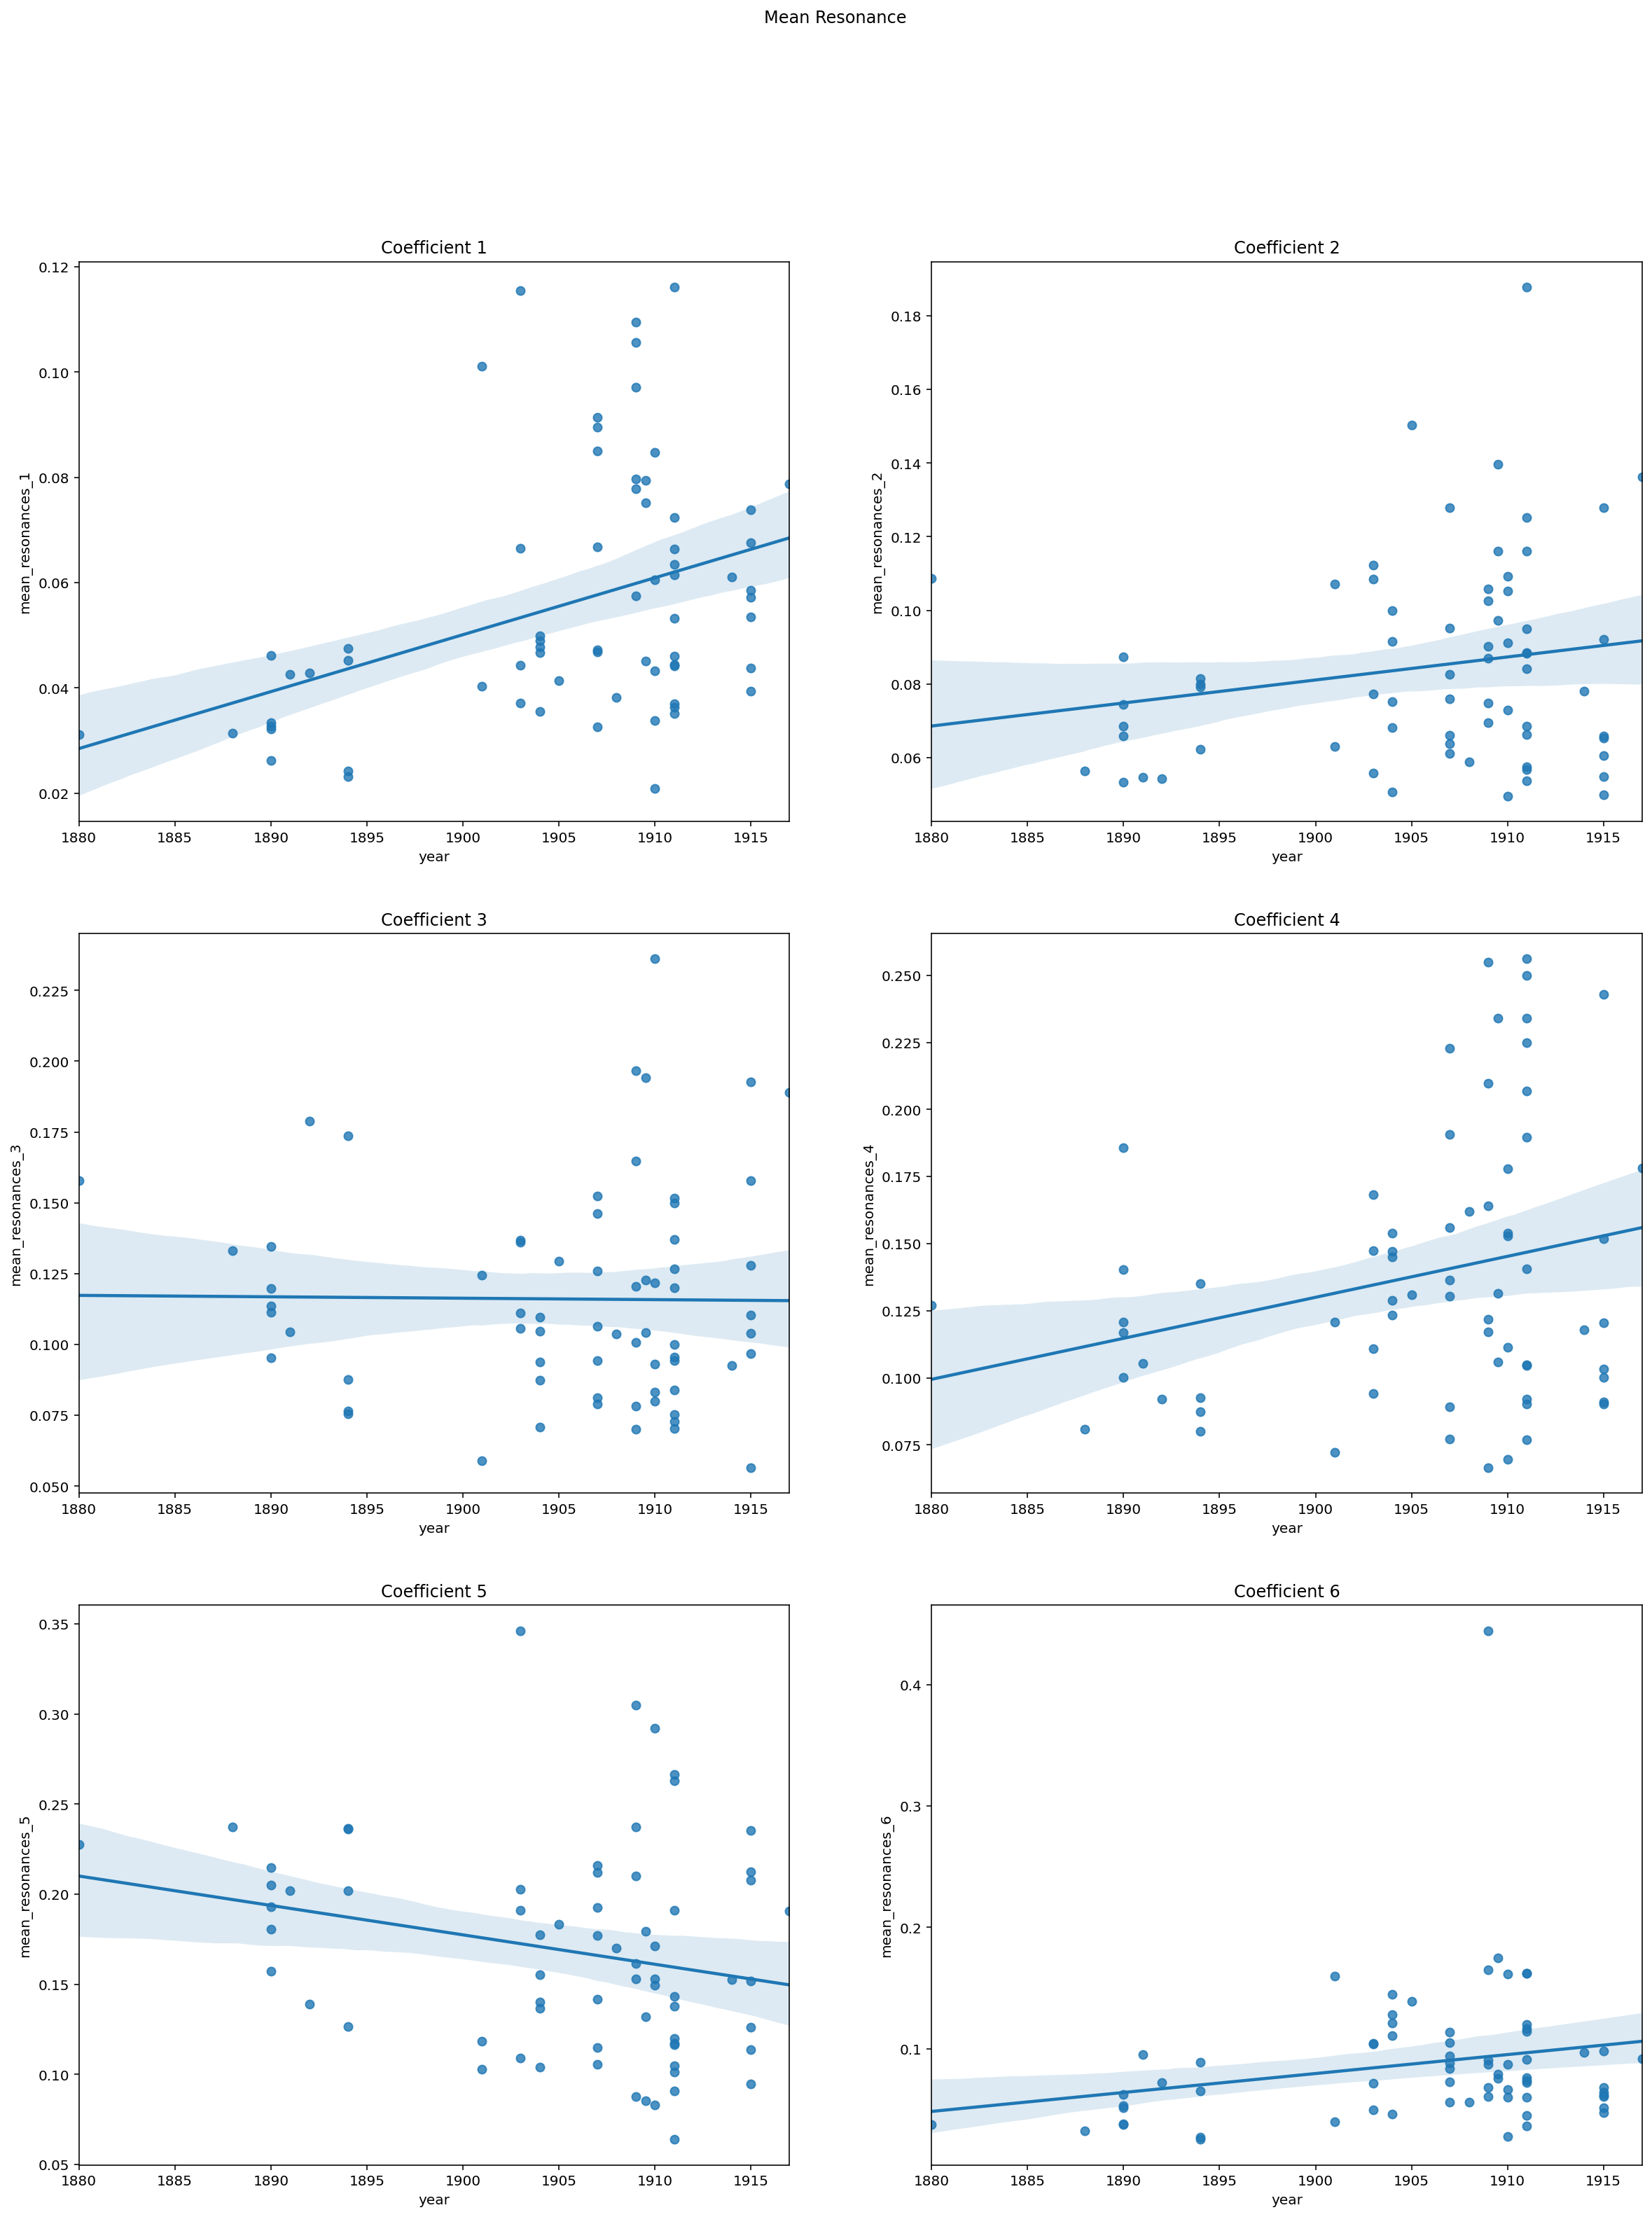

In [176]:
cols = [f"mean_resonances_{i}" for i in range(1,7)]

metadata_metrics = get_metric('mean_resonance', metadata_metrics, 
                              mag_phase_mx_dict=mag_phase_mx_dict,
                                     cols=cols, store_matrix=True, 
                                     show_plot=True, save_name='mean_resonances', title='Mean Resonance')
metadata_metrics.head(1)

# Moment of Inertia

“Moment of inertia” of coefficient n in the summary wavescape: I(n)=1NiS(n)wiyi2, where N is the total number of nodes in the wavescape, S(n) is the set of the indices of the nodes in the summary wavescapes that are attributed to coefficient n (i.e., where coefficient n is the most prominent among the six), w_i is the weight (opacity) of the i-th node in the summary wavescape, and y_i is the vertical coordinate of the i-th node in the summary wavescape


Found matrices for all files listed in metadata.tsv.
The example center of mass list has len 6.
Example results [0.00015947 0.00053329 0.01741228 0.06447828 0.03489523 0.00097629]


,rel_paths,last_mc,last_mn,length_qb,length_qb_unfolded,all_notes_qb,TimeSig,KeySig,label_count,composer,...,mean_resonances_3,mean_resonances_4,mean_resonances_5,mean_resonances_6,moments_of_inertia_1,moments_of_inertia_2,moments_of_inertia_3,moments_of_inertia_4,moments_of_inertia_5,moments_of_inertia_6
fnames,,,,,,,,,,,,,,,,,,,,,
l000_etude,MS3,73,71,284.0,284.0,959.25,1: 4/4,"1: -4, 7: 0, 9: -5, 38: 0, 42: -4, 48: -3, 57:...",0,Claude Debussy,...,0.103886,0.151917,0.151747,0.061724,0.000159,0.000533,0.017412,0.064478,0.034895,0.000976


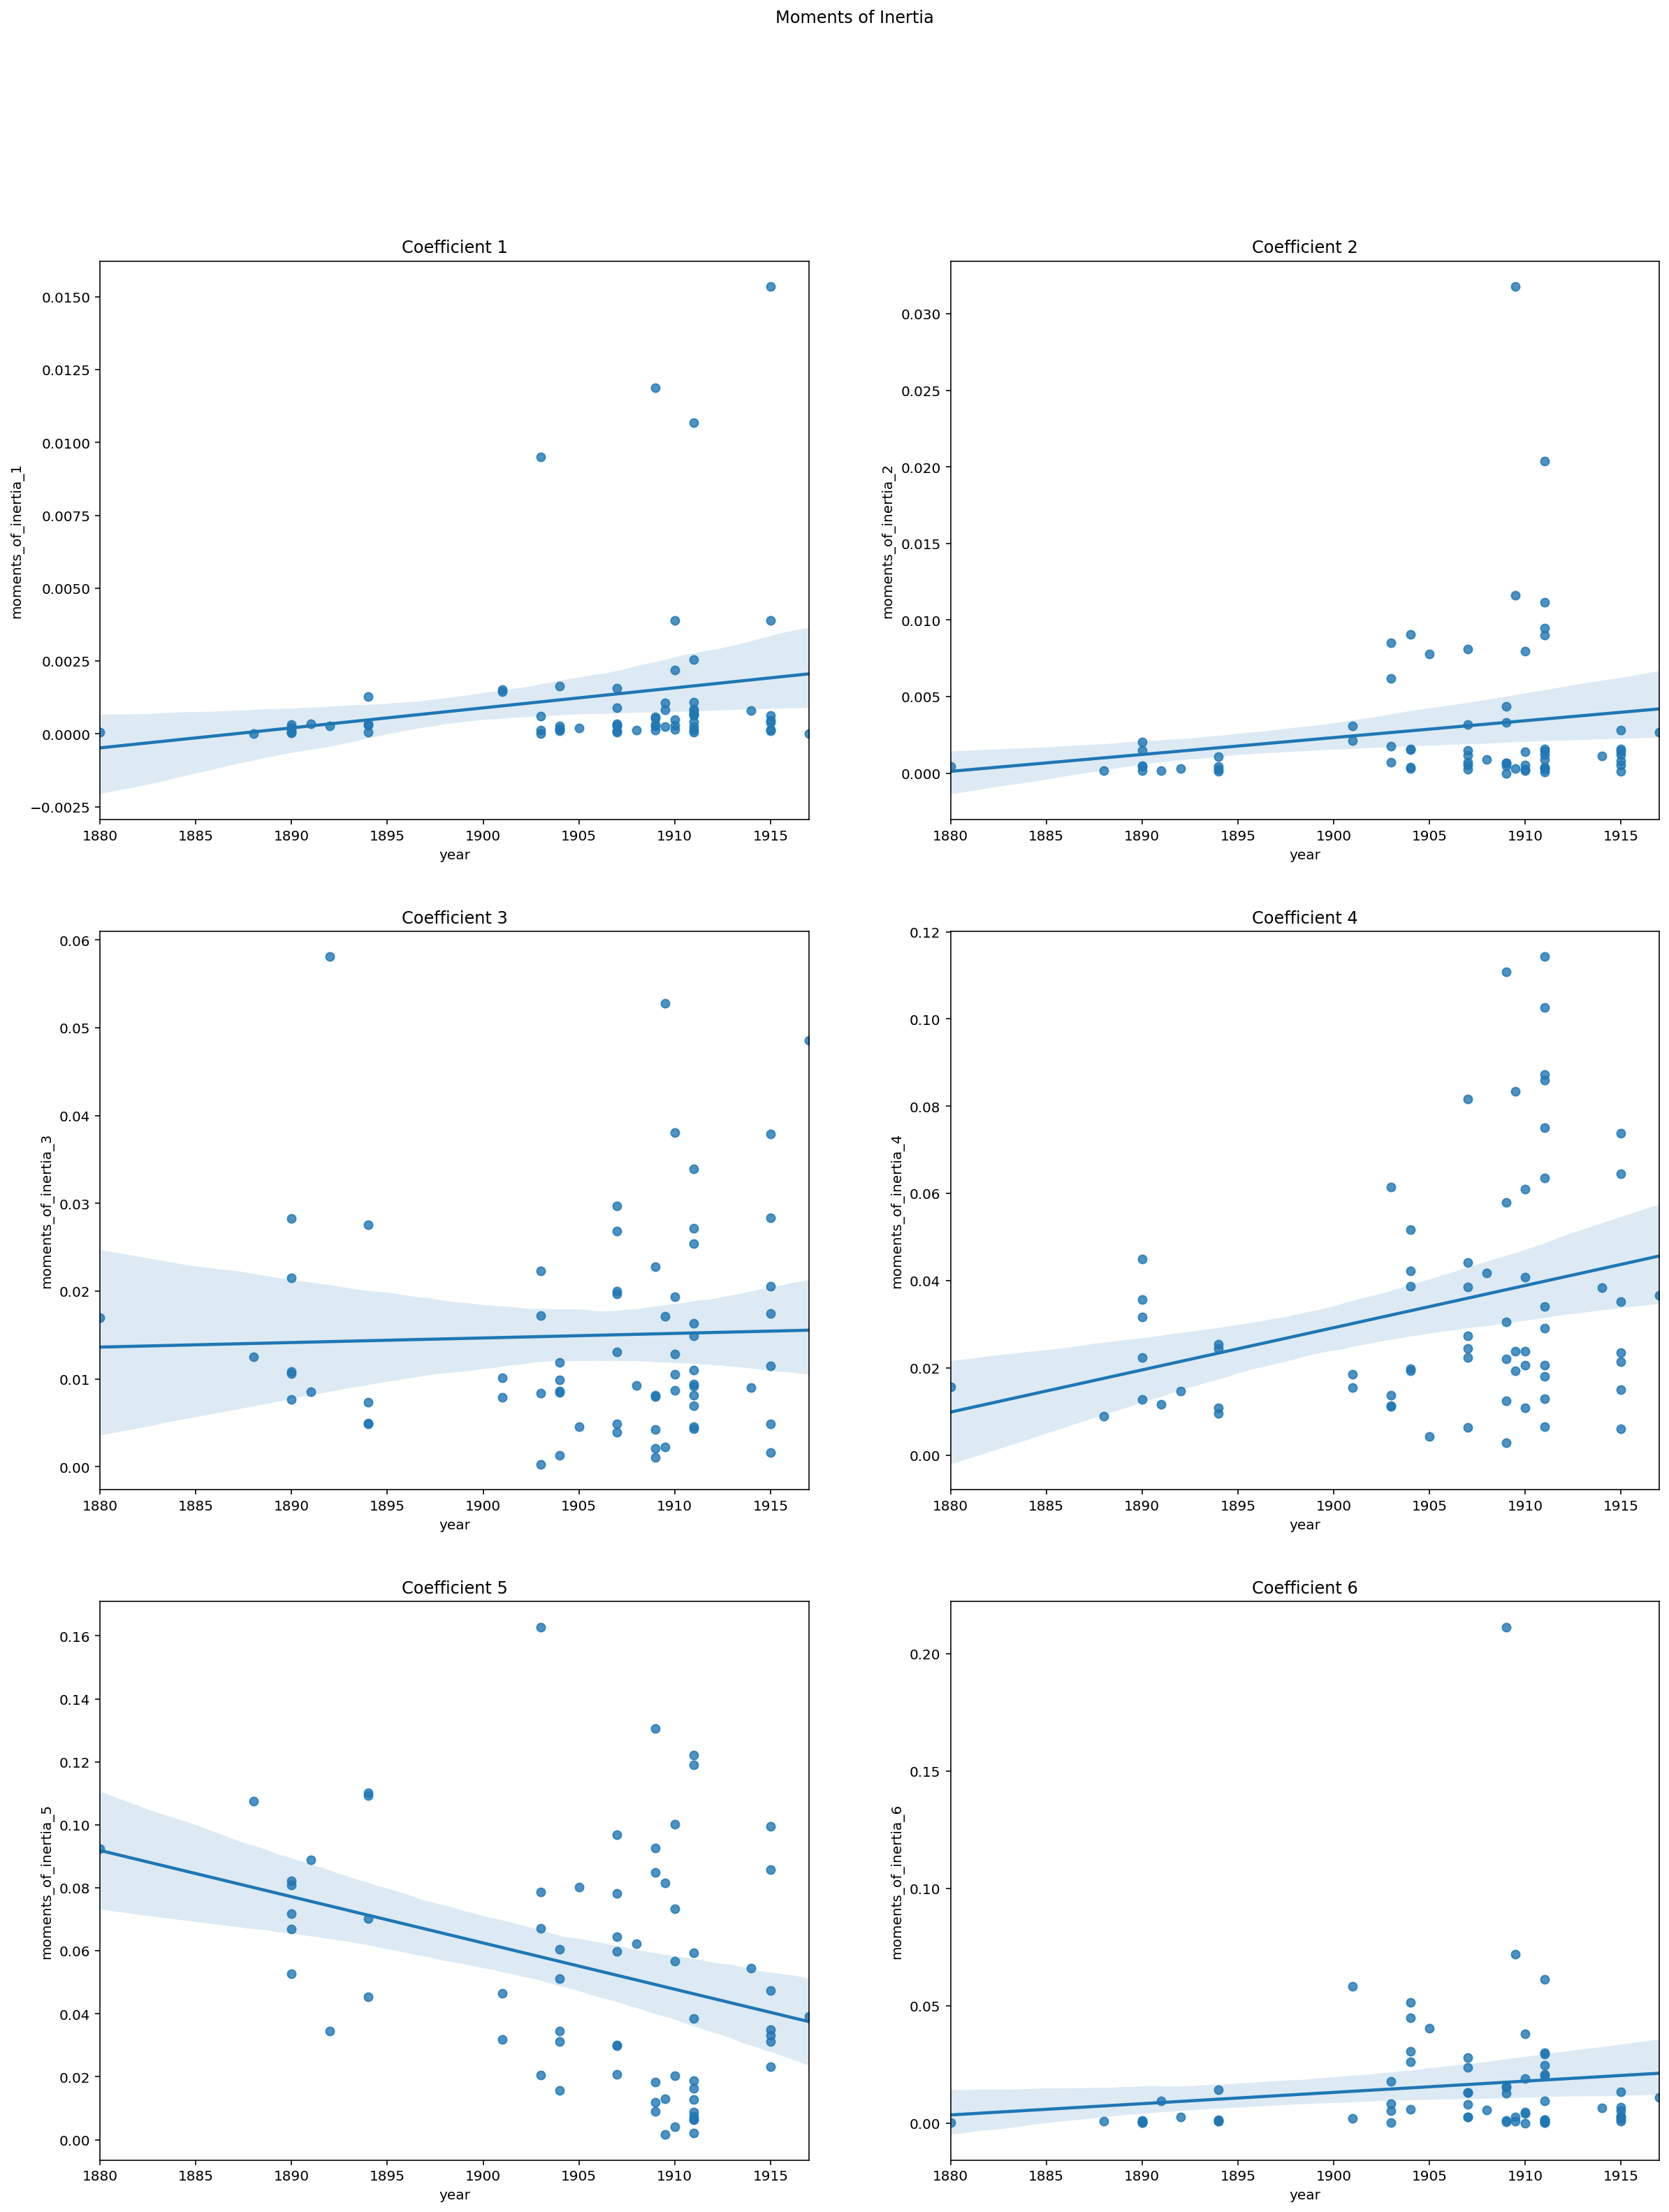

In [177]:
cols = [f"moments_of_inertia_{i}" for i in range(1,7)]

metadata_metrics = get_metric('moment_of_inertia', metadata_metrics, 
                              max_coeffs=max_coeffs,
                              max_mags=max_mags,
                              cols=cols, store_matrix=True, 
                              show_plot=True, save_name='moments_of_inertia', title='Moments of Inertia')
metadata_metrics.head(1)

# Prevalence of each coefficient

“Prevalence “ of coefficient n in a piece: W(n)=1NiS(n)wi where N is the total number of nodes in the wavescape, S(n) is the set of the indices of the nodes in the summary wavescapes that are attributed to coefficient n (i.e., where coefficient n is the most prominent among the six), and w_i is the weight (opacity) of the i-th node in the summary wavescape


Found matrices for all files listed in metadata.tsv.
The example center of mass list has len 6.
Example results [0.49846261 0.00101666 0.07786154 0.16114114 0.25954672 0.00197134]


,rel_paths,last_mc,last_mn,length_qb,length_qb_unfolded,all_notes_qb,TimeSig,KeySig,label_count,composer,...,moments_of_inertia_3,moments_of_inertia_4,moments_of_inertia_5,moments_of_inertia_6,percentage_resonances_1,percentage_resonances_2,percentage_resonances_3,percentage_resonances_4,percentage_resonances_5,percentage_resonances_6
fnames,,,,,,,,,,,,,,,,,,,,,
l000_etude,MS3,73,71,284.0,284.0,959.25,1: 4/4,"1: -4, 7: 0, 9: -5, 38: 0, 42: -4, 48: -3, 57:...",0,Claude Debussy,...,0.017412,0.064478,0.034895,0.000976,0.498463,0.001017,0.077862,0.161141,0.259547,0.001971


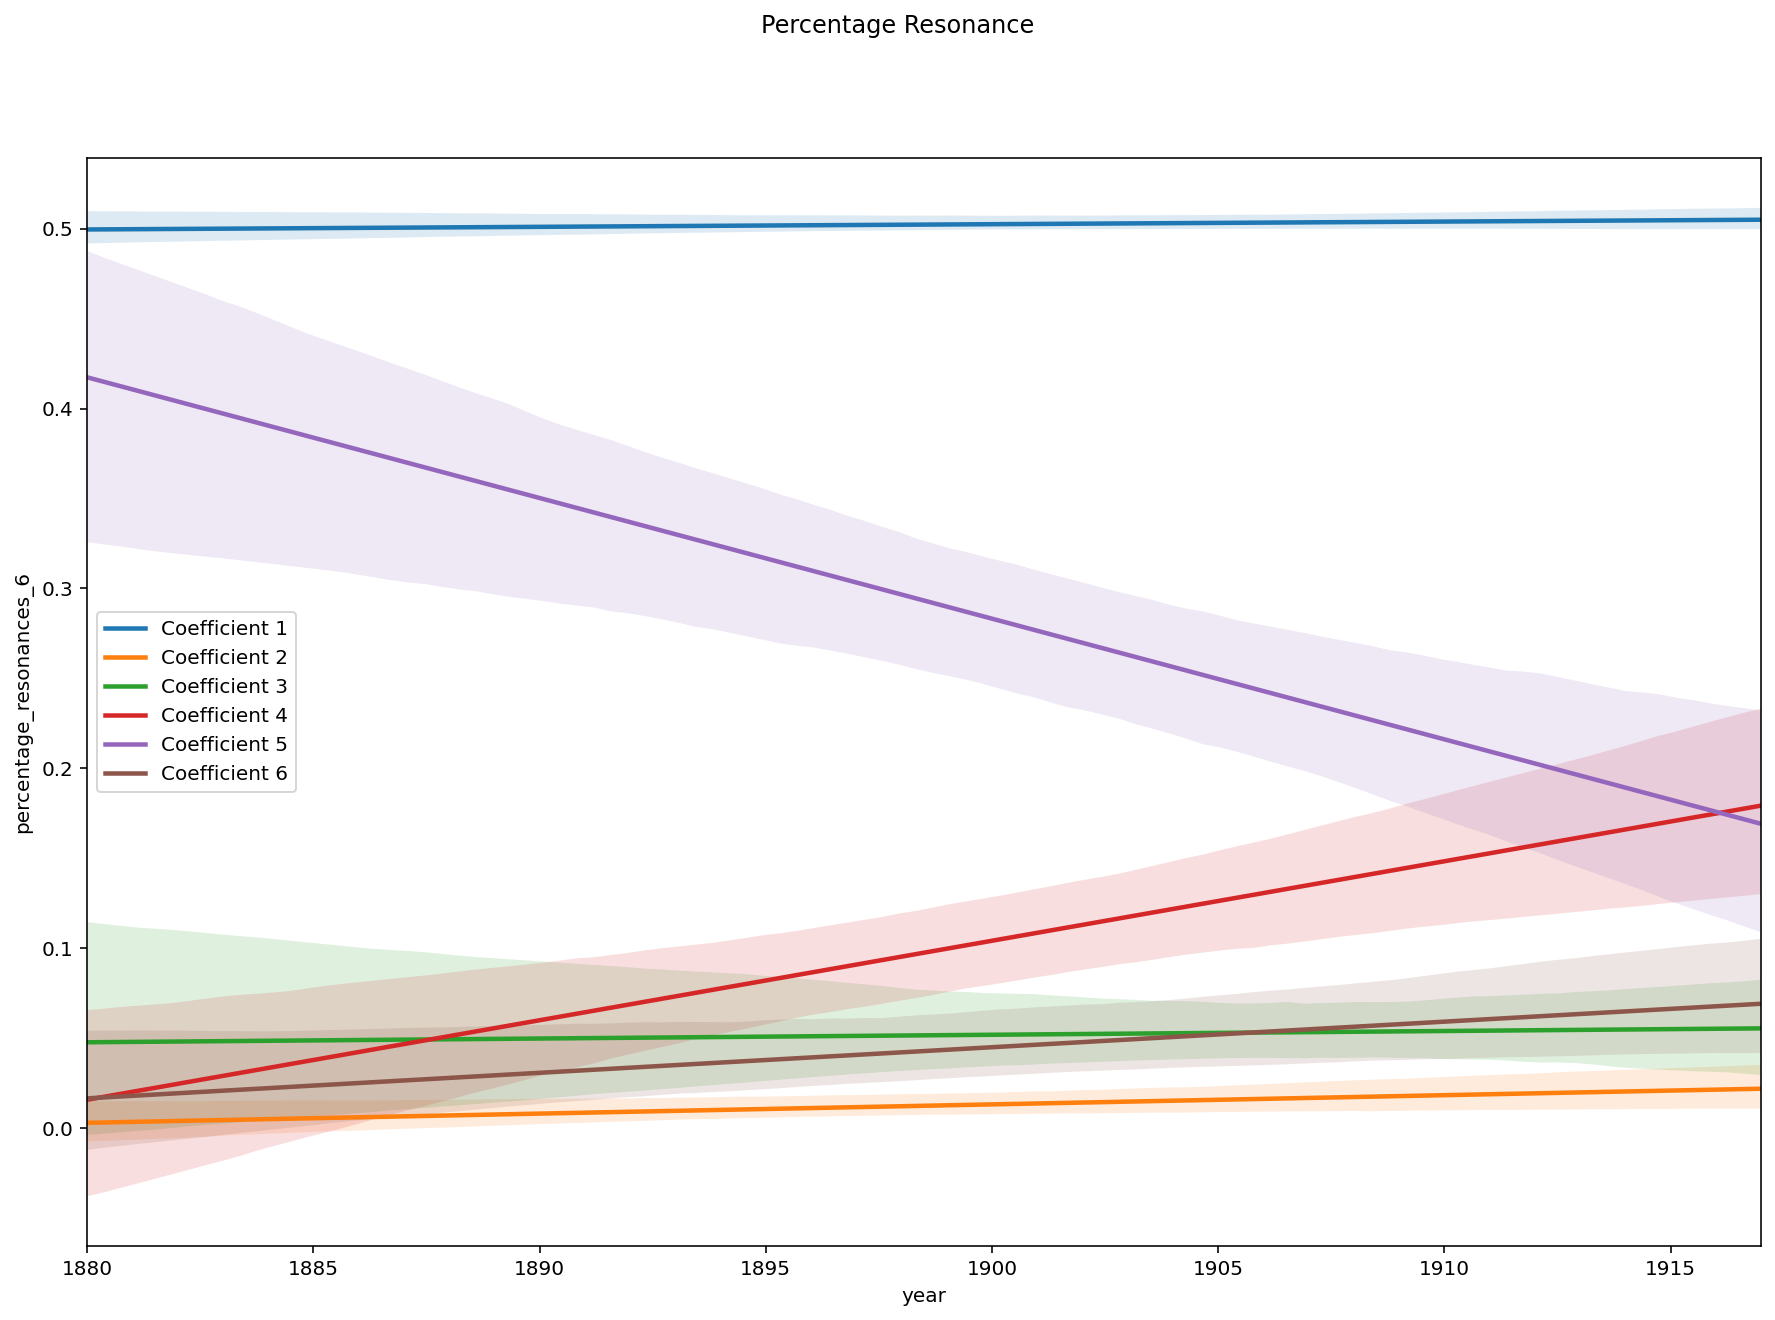

In [179]:
cols = [f"percentage_resonances_{i}" for i in range(1,7)]

metadata_metrics = get_metric('percentage_resonance', metadata_metrics, 
                              max_coeffs=max_coeffs,
                              cols=cols, store_matrix=True, 
                              show_plot=True, save_name='percentage_resonance', title='Percentage Resonance', unified=True)
metadata_metrics.head(1)

Found matrices for all files listed in metadata.tsv.
The example center of mass list has len 6.
Example results [1.84134713e-05 1.68494478e-04 1.81500753e-02 3.73207279e-02
 5.67370571e-02 2.92257347e-04]


,rel_paths,last_mc,last_mn,length_qb,length_qb_unfolded,all_notes_qb,TimeSig,KeySig,label_count,composer,...,percentage_resonances_3,percentage_resonances_4,percentage_resonances_5,percentage_resonances_6,percentage_resonances_entropy_1,percentage_resonances_entropy_2,percentage_resonances_entropy_3,percentage_resonances_entropy_4,percentage_resonances_entropy_5,percentage_resonances_entropy_6
fnames,,,,,,,,,,,,,,,,,,,,,
l000_etude,MS3,73,71,284.0,284.0,959.25,1: 4/4,"1: -4, 7: 0, 9: -5, 38: 0, 42: -4, 48: -3, 57:...",0,Claude Debussy,...,0.077862,0.161141,0.259547,0.001971,0.000018,0.000168,0.01815,0.037321,0.056737,0.000292


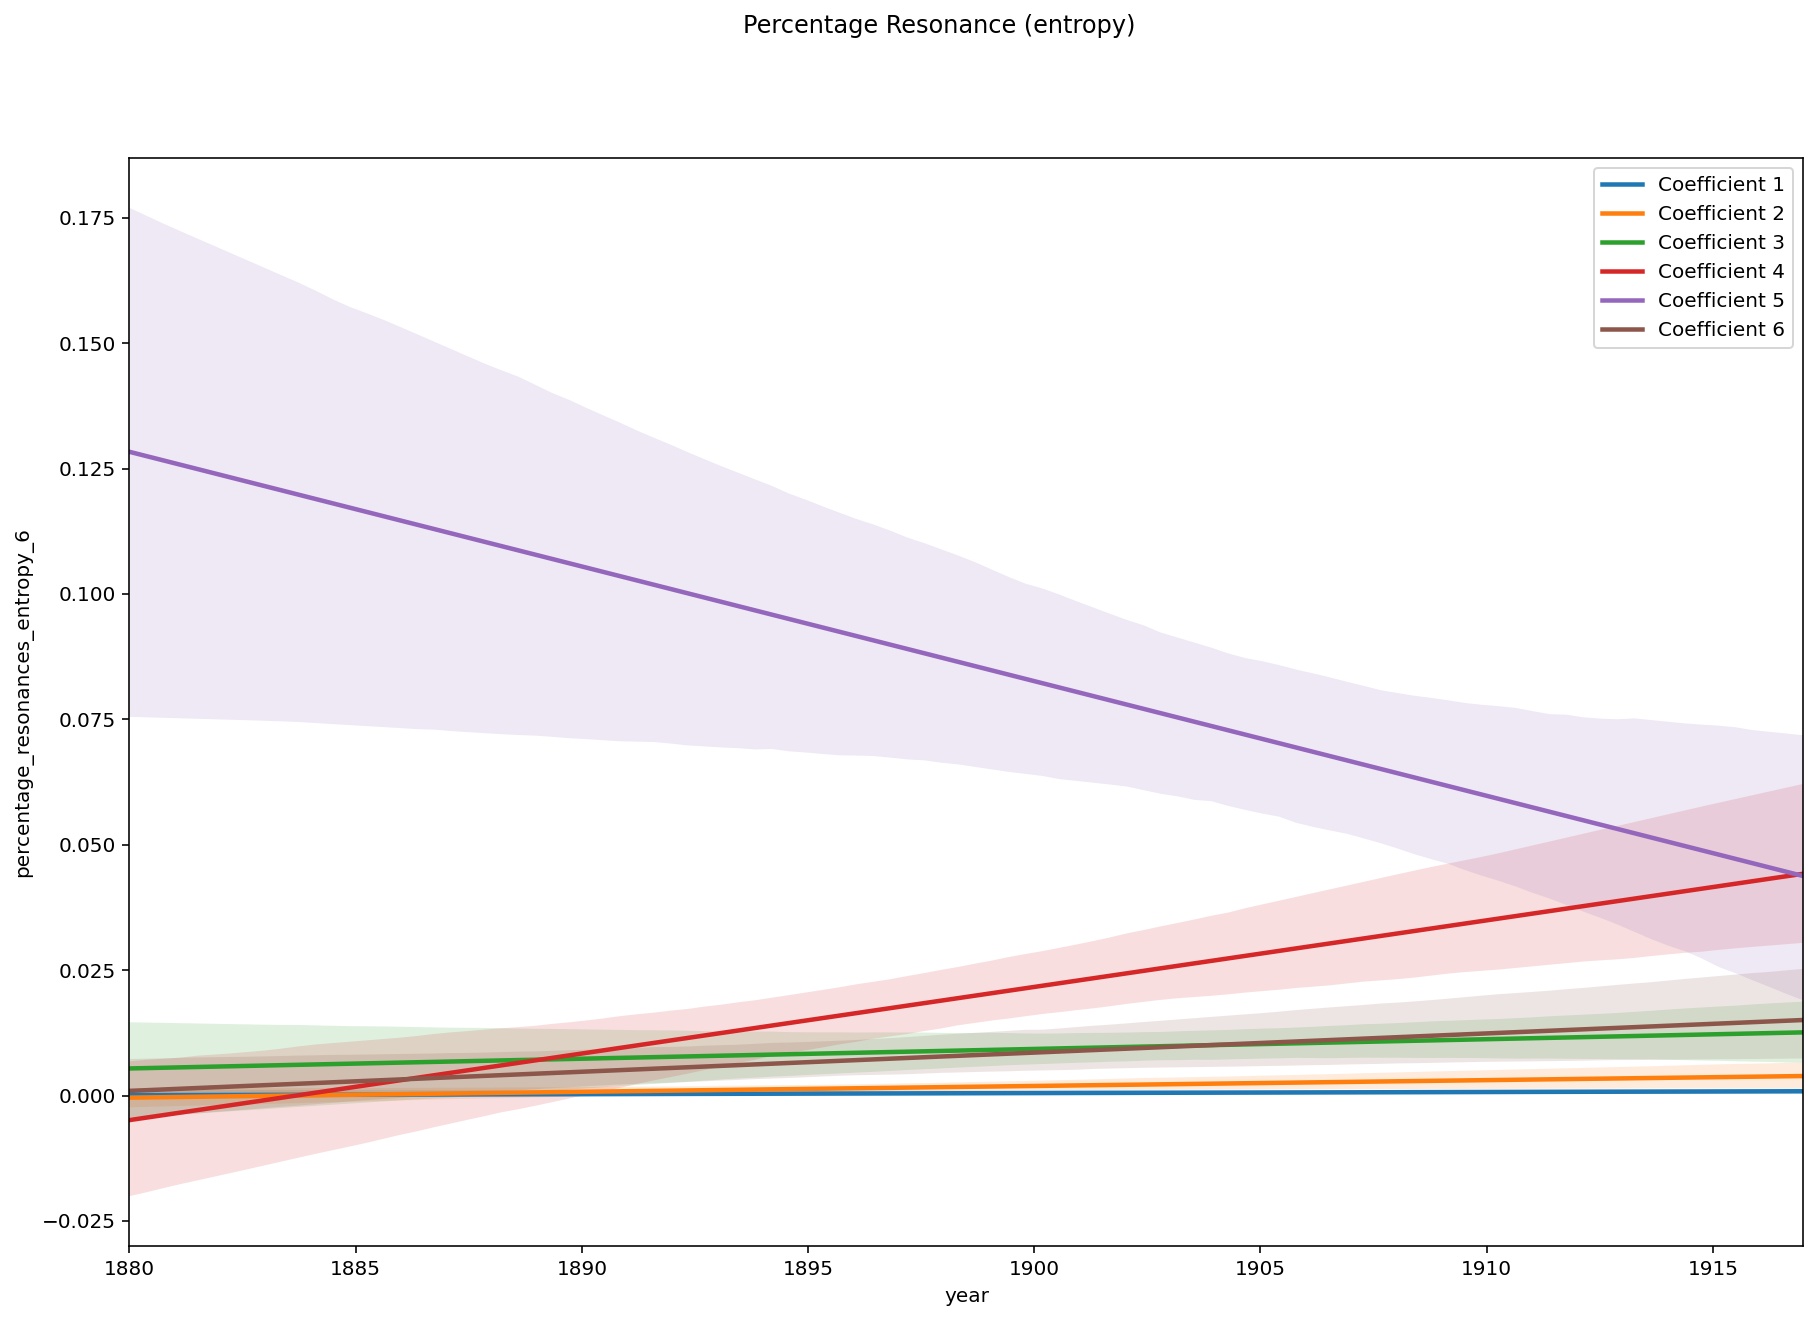

In [180]:
cols = [f"percentage_resonances_entropy_{i}" for i in range(1,7)]

metadata_metrics = get_metric('percentage_resonance_entropy', metadata_metrics, 
                              max_coeffs=max_coeffs,
                              inv_entropies=inv_entropies,
                              cols=cols, store_matrix=True, 
                              show_plot=True, save_name='percentage_resonance_entropy', title='Percentage Resonance (entropy)', unified=True)
metadata_metrics.head(1)

# Measure Theoretic Entropy

Measure-theoretic entropy: Let A={A1,,Ak} be a (finite) partition of a probability space (X,P(X),): the entropy of the partition A is defined as H(A)=-i(Ai)(Ai). We can take X as the support of the wavescape, A as the set of the connected regions in the unified wavescape, and (Y)=(area of Y)/(area of X) for any subset Y of the wavescape


degree of fragmentation by entropy of the connected components' areas: Let A={A1,,Ak} be a (finite) partition of a probability space (X,P(X),): the entropy of the partition A is defined as H(A)=-i(Ai)(Ai). We can take X as the support of the wavescape, A as the set of the connected regions in the unified wavescape, and (Y)=(area of Y)/(area of X) for any subset Y of the wavescape.


In [181]:
# takes quite long
cols = 'partition_entropy'

metadata_metrics = get_metric('partition_entropy', metadata_metrics, 
                              max_coeffs=max_coeffs,
                              cols=cols, store_matrix=True, 
                              show_plot=True, save_name='partition_entropy', title='Partition Entropy', unified=True)
metadata_metrics.head(1)

KeyboardInterrupt: 

# Decreasing magnitude in height

1


,rel_paths,last_mc,last_mn,length_qb,length_qb_unfolded,all_notes_qb,TimeSig,KeySig,label_count,composer,...,percentage_resonances_4,percentage_resonances_5,percentage_resonances_6,percentage_resonances_entropy_1,percentage_resonances_entropy_2,percentage_resonances_entropy_3,percentage_resonances_entropy_4,percentage_resonances_entropy_5,percentage_resonances_entropy_6,inverse_coherence
fnames,,,,,,,,,,,,,,,,,,,,,
l000_etude,MS3,73,71,284.0,284.0,959.25,1: 4/4,"1: -4, 7: 0, 9: -5, 38: 0, 42: -4, 48: -3, 57:...",0,Claude Debussy,...,0.161141,0.259547,0.001971,0.000018,0.000168,0.01815,0.037321,0.056737,0.000292,0.030475


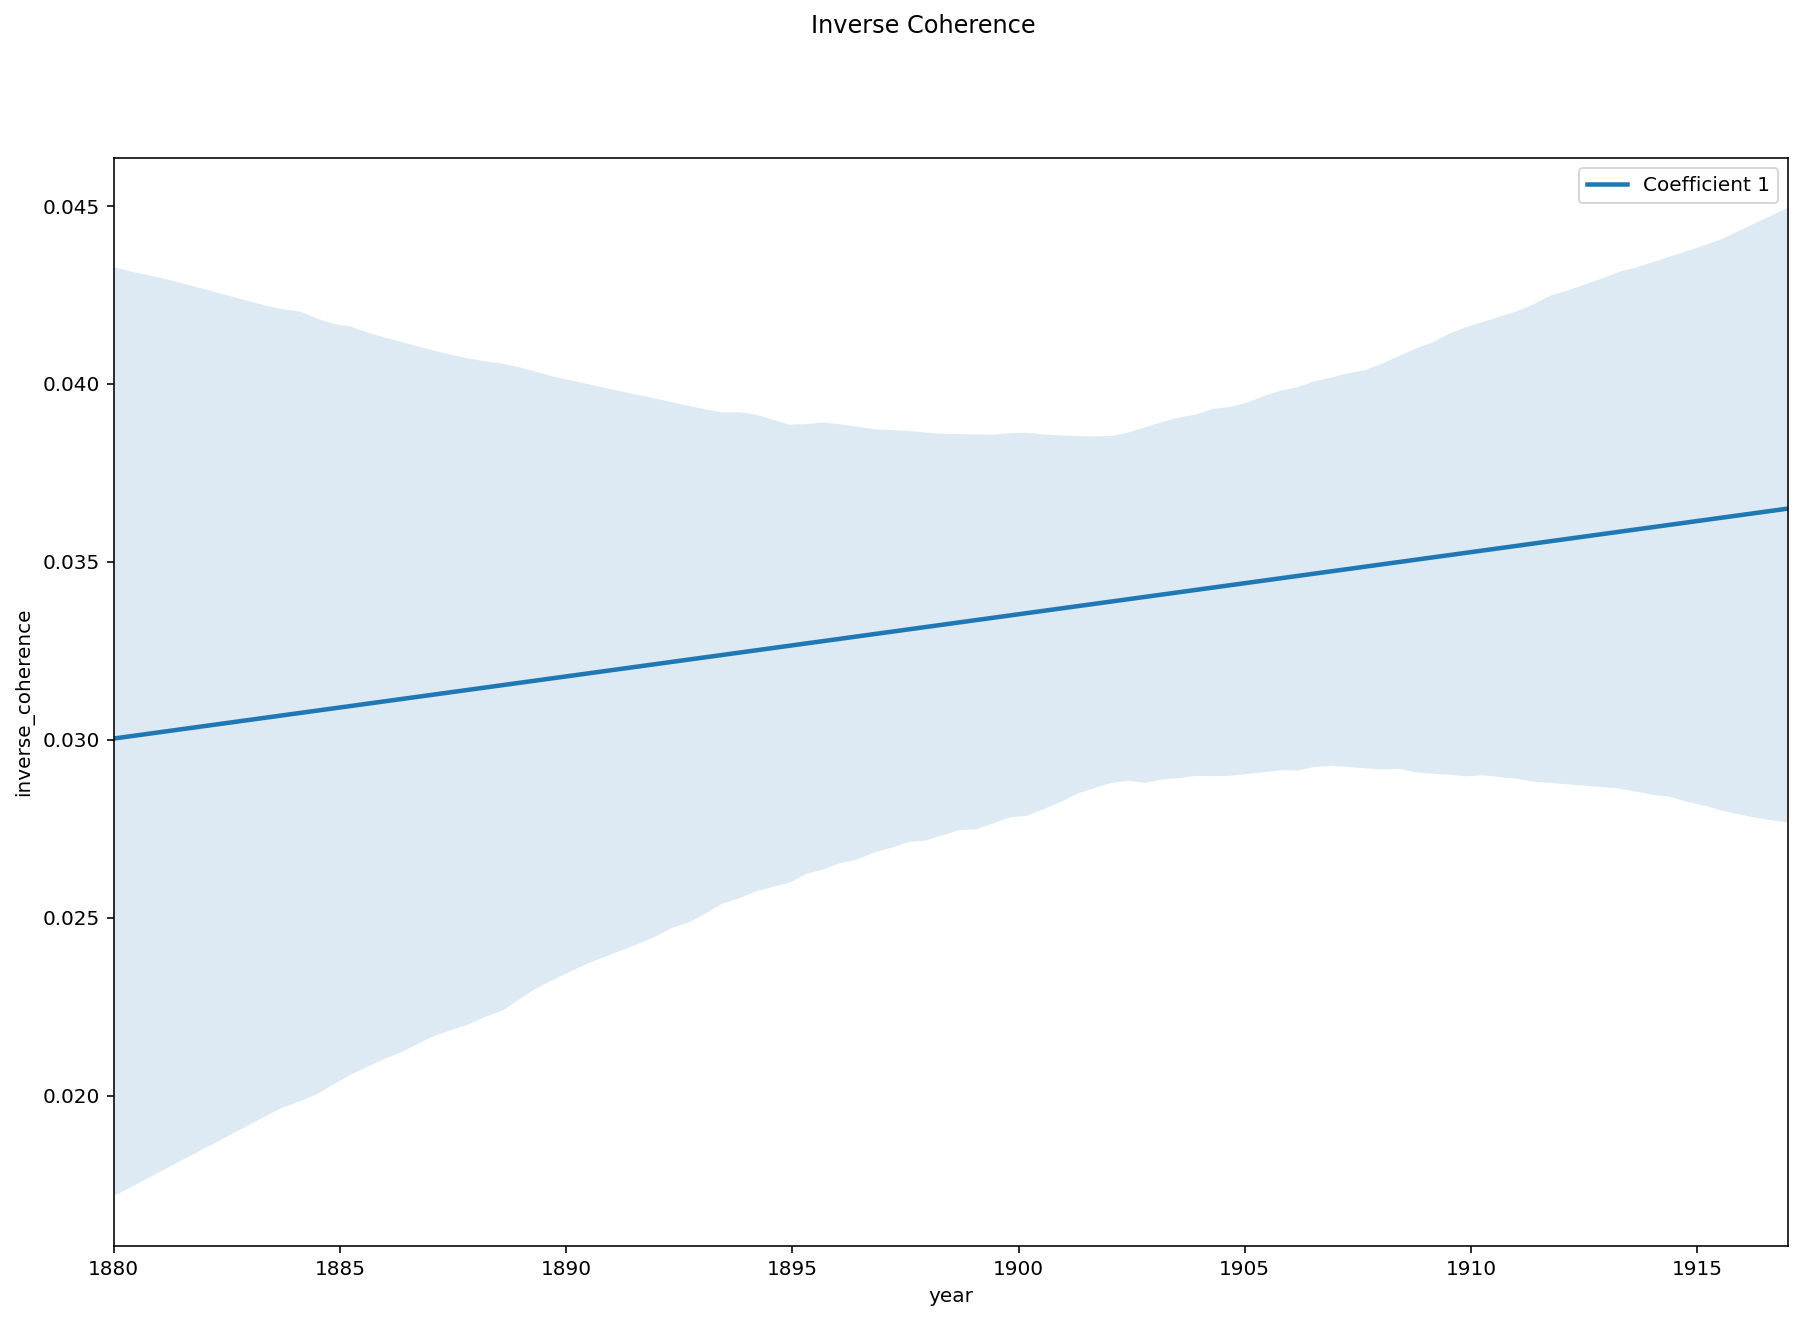

In [188]:
cols = 'inverse_coherence'

metadata_metrics = get_metric('inverse_coherence', metadata_metrics, 
                              max_mags=max_mags,
                              cols=cols, store_matrix=True, 
                              show_plot=True, save_name='inverse_coherence', title='Inverse Coherence', unified=True)
metadata_metrics.head(1)

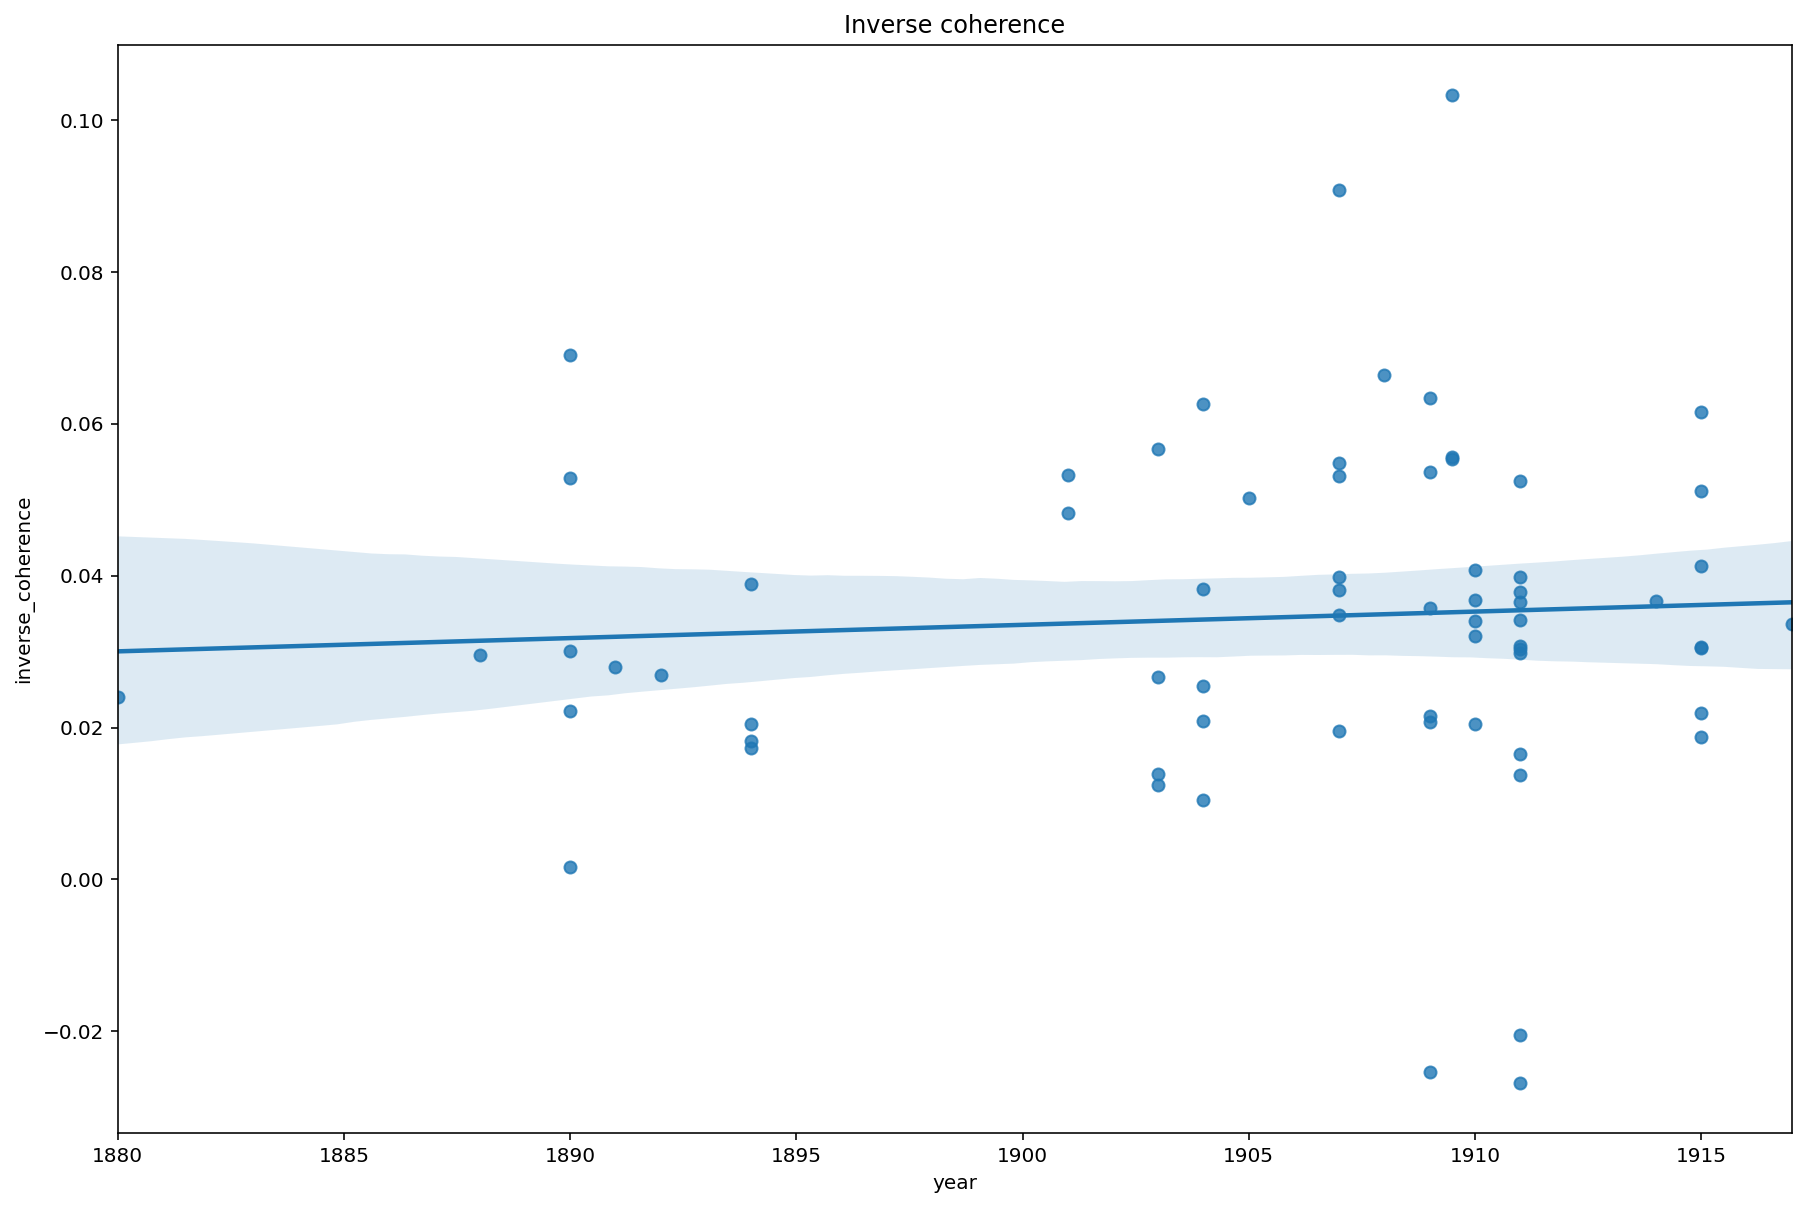

In [184]:
fig, ax = plt.subplots(1,1, figsize=(15,10))
plt.title("Inverse coherence")
sns.regplot(x='year', y='inverse_coherence', data=metadata_metrics)
plt.savefig('figures/inverse_coherence.png')

In [185]:
metadata_metrics.to_csv('metrics.csv')